In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'legend.fontsize': 14})
#plt.rcParams['font.family'] = 'times'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
import uproot

In [2]:
##### function definitions
# different definitions of hadronic energy
def cal_Ehadtrue(pdg, E, m):
    Ehadtrue = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212, 2112]:
            Ehadtrue += (E[ip] - m[ip])
        elif pdg[ip] in [211, -211, 111, 22, 321, -321, 311]:
            Ehadtrue += E[ip]
    return Ehadtrue
def cal_Ehadreco(pdg, E, m):
    Ehadreco = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212]:
            Ehadreco += (E[ip] - m[ip])
        elif pdg[ip] in [211, -211, 111, 22, 321, -321, 311]:
            Ehadreco += E[ip]
    return Ehadreco
def cal_Eavail(pdg, E, m):
    Eavail = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212, 211, -211]:
            Eavail += (E[ip] - m[ip])
        elif pdg[ip] in [111, 22, 321, -321, 311]:
            Eavail += E[ip]
    return Eavail
def get_Ehad_array(vars_dict, cal_Ehad_func):
    nevts = len(vars_dict["Ev"])
    pdgi = vars_dict["pdgi"]
    Ei = vars_dict["Ei"]
    mi = []
    Eavail_i = []
    pdgf = vars_dict["pdgf"]
    Ef = vars_dict["Ef"]
    mf = []
    Eavail_f = []
    
    for ievt in range(nevts):
        pisq = vars_dict["pxi"][ievt]*vars_dict["pxi"][ievt] + vars_dict["pyi"][ievt]*vars_dict["pyi"][ievt] + vars_dict["pzi"][ievt]*vars_dict["pzi"][ievt]
        mi.append(np.sqrt(Ei[ievt]*Ei[ievt] - pisq))
        Eavail_i.append(cal_Ehad_func(pdgi[ievt], Ei[ievt], mi[ievt]))
        
        mf.append(np.sqrt(Ef[ievt]*Ef[ievt] - vars_dict["pf"][ievt]*vars_dict["pf"][ievt]))
        Eavail_f.append(cal_Ehad_func(pdgf[ievt], Ef[ievt], mf[ievt]))
        
    return np.array(Eavail_i), np.array(Eavail_f)

# neutrino energy bias
def get_Ebias(vars_dict, cal_Ehad_func):
    Ehadi, Ehadf = get_Ehad_array(vars_dict, cal_Ehad_func)
    return vars_dict["El"] + Ehadi - vars_dict["Ev"], vars_dict["El"] + Ehadf - vars_dict["Ev"]
def get_relative_Ebias(vars_dict, cal_Ehad_func):
    Ebiasi, Ebiasf = get_Ebias(vars_dict, cal_Ehad_func)
    return Ebiasi / vars_dict["Ev"], Ebiasf / vars_dict["Ev"]

# other useful
def safe_divide(numerator, denominator, default_value=100):
    # 0/0 = 1, 0/x = 0, x/0 = default_value
    result = np.ones_like(numerator, dtype=float)  # Default result is 1
    mask_both_zero = (numerator == 0) & (denominator == 0)
    mask_only_denominator_zero = (denominator == 0) & ~mask_both_zero

    result[~mask_both_zero & ~mask_only_denominator_zero] = numerator[~mask_both_zero & ~mask_only_denominator_zero] / denominator[~mask_both_zero & ~mask_only_denominator_zero]
    result[mask_only_denominator_zero] = default_value  # Assign default value where denominator is zero and numerator is non-zero
    return np.nan_to_num(result, nan=default_value)  # Replace NaN with default_value

def fill_between_gradient(ax, x, y, y_upp, y_low,
                          alpha=0.3, resolution=1000, zorder=0,
                          cmap=None, label=None):
    """
    Draw a vertical red-white-blue gradient between y_upp and y_low on the given axes.
    White is centered at y(x), red at y_upp, and blue at y_low.

    Parameters:
    - ax: matplotlib Axes object
    - x: 1D array of x-coordinates
    - y: 1D array for the white center line
    - y_upp: 1D array for the red-side boundary
    - y_low: 1D array for the blue-side boundary
    - alpha: float (0 to 1), maximum opacity of the fill
    - resolution: int, resolution for the rendered gradient image
    - zorder: drawing layer
    - cmap: optional colormap (default is red-white-blue)
    - label: optional label (not used in legend but allows consistent API)
    """
    import numpy as np
    from scipy.interpolate import interp1d
    from matplotlib.colors import LinearSegmentedColormap

    if cmap is None:
        cmap = LinearSegmentedColormap.from_list("rwb", ["blue", "white", "red"])

    # Ensure input as arrays
    x = np.asarray(x)
    y = np.asarray(y)
    y_upp = np.asarray(y_upp)
    y_low = np.asarray(y_low)

    dy = (y_upp - y_low) / 2

    # Create meshgrid for plotting
    nx, ny = resolution, resolution
    X = np.linspace(x.min(), x.max(), nx)
    Y = np.linspace(min(y_upp.min(), y_low.min()) - 0.2,
                    max(y_upp.max(), y_low.max()) + 0.2, ny)
    XX, YY = np.meshgrid(X, Y)

    # Interpolate center and width to the mesh x values
    center_func = interp1d(x, y, bounds_error=False, fill_value="extrapolate")
    dy_func = interp1d(x, dy, bounds_error=False, fill_value="extrapolate")
    y0 = center_func(X)
    dy_vals = dy_func(X)

    # Interpolate upper/lower bounds *before* evaluating the mask
    y_upp_interp = interp1d(x, y_upp, bounds_error=False, fill_value="extrapolate")(X)
    y_low_interp = interp1d(x, y_low, bounds_error=False, fill_value="extrapolate")(X)
    y_top = np.maximum(y_upp_interp, y_low_interp)
    y_bot = np.minimum(y_upp_interp, y_low_interp)

    # Safe division to normalize gradient [-1, 1]
    def safe_divide(numerator, denominator, default_value=100):
        numerator, denominator = np.broadcast_arrays(numerator, denominator)
        result = np.ones_like(numerator)
        mask_both_zero = (numerator == 0) & (denominator == 0)
        mask_only_zero = (denominator == 0) & ~mask_both_zero
        mask_valid = ~mask_both_zero & ~mask_only_zero
        result[mask_valid] = numerator[mask_valid] / denominator[mask_valid]
        result[mask_only_zero] = default_value
        return np.nan_to_num(result, nan=default_value)

    norm_val = safe_divide(YY - y0, dy_vals)
    norm_val = np.clip(norm_val, -1, 1)

    # Alpha mask: only show pixels between the two bounds
    alpha_mask = ((YY >= y_bot) & (YY <= y_top)).astype(float) * alpha

    # Draw the image
    ax.imshow(norm_val,
              extent=[X.min(), X.max(), Y.min(), Y.max()],
              origin='lower',
              aspect='auto',
              cmap=cmap,
              alpha=alpha_mask,
              zorder=zorder,
              label=label)


### numubar oscillation

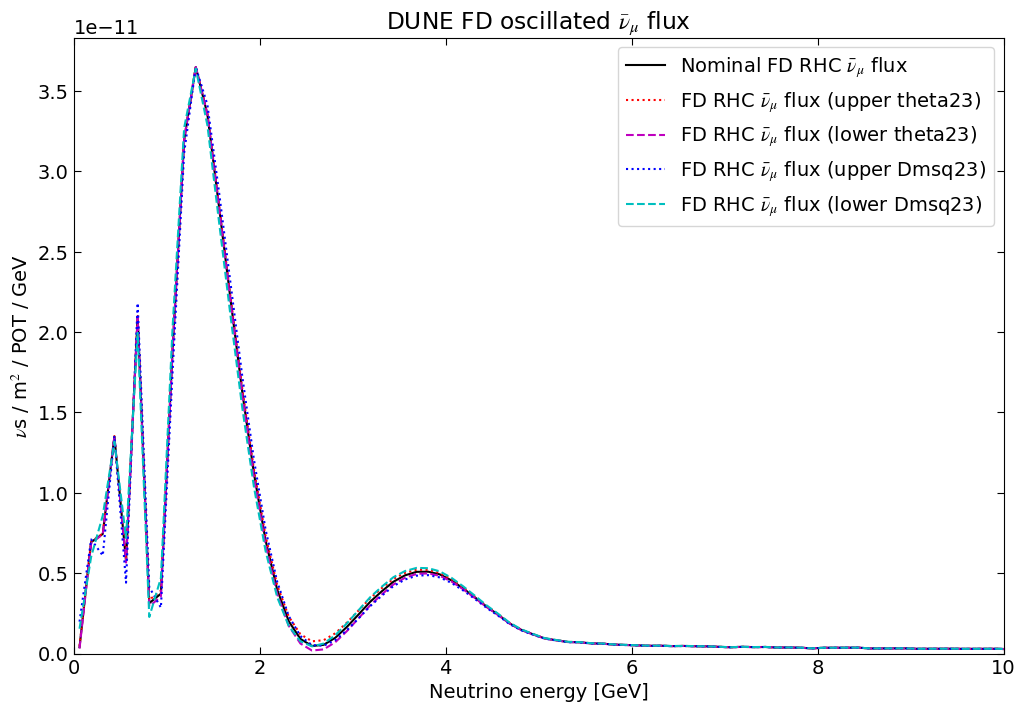

In [3]:
# curves generated from Prob3++ /exp/dune/app/users/yinrui/Oscillation/Prob3-Wrapper/example_nubar.C
FDosc_Ev = np.array([0.0625,0.1875,0.3125,0.4375,0.5625,0.6875,0.8125,0.9375,1.0625,1.1875,1.3125,1.4375,1.5625,1.6875,1.8125,1.9375,2.0625,2.1875,2.3125,2.4375,2.5625,2.6875,2.8125,2.9375,3.0625,3.1875,3.3125,3.4375,3.5625,3.6875,3.8125,3.9375,4.0625,4.1875,4.3125,4.4375,4.5625,4.6875,4.8125,4.9375,5.0625,5.1875,5.3125,5.4375,5.5625,5.6875,5.8125,5.9375,6.0625,6.1875,6.3125,6.4375,6.5625,6.6875,6.8125,6.9375,7.0625,7.1875,7.3125,7.4375,7.5625,7.6875,7.8125,7.9375,8.0625,8.1875,8.3125,8.4375,8.5625,8.6875,8.8125,8.9375,9.0625,9.1875,9.3125,9.4375,9.5625,9.6875,9.8125,9.9375,10.0625,10.1875,10.3125,10.4375,10.5625,10.6875,10.8125,10.9375,11.0625,11.1875,11.3125,11.4375,11.5625,11.6875,11.8125,11.9375,12.0625,12.1875,12.3125,12.4375,12.5625,12.6875,12.8125,12.9375,13.0625,13.1875,13.3125,13.4375,13.5625,13.6875,13.8125,13.9375,14.0625,14.1875,14.3125,14.4375,14.5625,14.6875,14.8125,14.9375,15.0625,15.1875,15.3125,15.4375,15.5625,15.6875,15.8125,15.9375,16.0625,16.1875,16.3125,16.4375,16.5625,16.6875,16.8125,16.9375,17.0625,17.1875,17.3125,17.4375,17.5625,17.6875,17.8125,17.9375,18.0625,18.1875,18.3125,18.4375,18.5625,18.6875,18.8125,18.9375,19.0625,19.1875,19.3125,19.4375,19.5625,19.6875,19.8125,19.9375,20.0625,20.1875,20.3125,20.4375,20.5625,20.6875,20.8125,20.9375,21.0625,21.1875,21.3125,21.4375,21.5625,21.6875,21.8125,21.9375,22.0625,22.1875,22.3125,22.4375,22.5625,22.6875,22.8125,22.9375,23.0625,23.1875,23.3125,23.4375,23.5625,23.6875,23.8125,23.9375,24.0625,24.1875,24.3125,24.4375,24.5625,24.6875,24.8125,24.9375,25.0625,25.1875,25.3125,25.4375,25.5625,25.6875,25.8125,25.9375,26.0625,26.1875,26.3125,26.4375,26.5625,26.6875,26.8125,26.9375,27.0625,27.1875,27.3125,27.4375,27.5625,27.6875,27.8125,27.9375,28.0625,28.1875,28.3125,28.4375,28.5625,28.6875,28.8125,28.9375,29.0625,29.1875,29.3125,29.4375,29.5625,29.6875,29.8125,29.9375,30.0625,30.1875,30.3125,30.4375,30.5625,30.6875,30.8125,30.9375,31.0625,31.1875,31.3125,31.4375,31.5625,31.6875,31.8125,31.9375,32.0625,32.1875,32.3125,32.4375,32.5625,32.6875,32.8125,32.9375,33.0625,33.1875,33.3125,33.4375,33.5625,33.6875,33.8125,33.9375,34.0625,34.1875,34.3125,34.4375,34.5625,34.6875,34.8125,34.9375,35.0625,35.1875,35.3125,35.4375,35.5625,35.6875,35.8125,35.9375,36.0625,36.1875,36.3125,36.4375,36.5625,36.6875,36.8125,36.9375,37.0625,37.1875,37.3125,37.4375,37.5625,37.6875,37.8125,37.9375,38.0625,38.1875,38.3125,38.4375,38.5625,38.6875,38.8125,38.9375,39.0625,39.1875,39.3125,39.4375,39.5625,39.6875,39.8125,39.9375,40.0625,40.1875,40.3125,40.4375,40.5625,40.6875,40.8125,40.9375,41.0625,41.1875,41.3125,41.4375,41.5625,41.6875,41.8125,41.9375,42.0625,42.1875,42.3125,42.4375,42.5625,42.6875,42.8125,42.9375,43.0625,43.1875,43.3125,43.4375,43.5625,43.6875,43.8125,43.9375,44.0625,44.1875,44.3125,44.4375,44.5625,44.6875,44.8125,44.9375,45.0625,45.1875,45.3125,45.4375,45.5625,45.6875,45.8125,45.9375,46.0625,46.1875,46.3125,46.4375,46.5625,46.6875,46.8125,46.9375,47.0625,47.1875,47.3125,47.4375,47.5625,47.6875,47.8125,47.9375,48.0625,48.1875,48.3125,48.4375,48.5625,48.6875,48.8125,48.9375,49.0625,49.1875,49.3125,49.4375,49.5625,49.6875,49.8125,49.9375,50.0625,50.1875,50.3125,50.4375,50.5625,50.6875,50.8125,50.9375,51.0625,51.1875,51.3125,51.4375,51.5625,51.6875,51.8125,51.9375,52.0625,52.1875,52.3125,52.4375,52.5625,52.6875,52.8125,52.9375,53.0625,53.1875,53.3125,53.4375,53.5625,53.6875,53.8125,53.9375,54.0625,54.1875,54.3125,54.4375,54.5625,54.6875,54.8125,54.9375,55.0625,55.1875,55.3125,55.4375,55.5625,55.6875,55.8125,55.9375,56.0625,56.1875,56.3125,56.4375,56.5625,56.6875,56.8125,56.9375,57.0625,57.1875,57.3125,57.4375,57.5625,57.6875,57.8125,57.9375,58.0625,58.1875,58.3125,58.4375,58.5625,58.6875,58.8125,58.9375,59.0625,59.1875,59.3125,59.4375,59.5625,59.6875,59.8125,59.9375,60.0625,60.1875,60.3125,60.4375,60.5625,60.6875,60.8125,60.9375,61.0625,61.1875,61.3125,61.4375,61.5625,61.6875,61.8125,61.9375,62.0625,62.1875,62.3125,62.4375,62.5625,62.6875,62.8125,62.9375,63.0625,63.1875,63.3125,63.4375,63.5625,63.6875,63.8125,63.9375,64.0625,64.1875,64.3125,64.4375,64.5625,64.6875,64.8125,64.9375,65.0625,65.1875,65.3125,65.4375,65.5625,65.6875,65.8125,65.9375,66.0625,66.1875,66.3125,66.4375,66.5625,66.6875,66.8125,66.9375,67.0625,67.1875,67.3125,67.4375,67.5625,67.6875,67.8125,67.9375,68.0625,68.1875,68.3125,68.4375,68.5625,68.6875,68.8125,68.9375,69.0625,69.1875,69.3125,69.4375,69.5625,69.6875,69.8125,69.9375])
ND_Flux_RHCnumubar = np.array([2.91243e-05, 5.3149e-05, 6.51693e-05, 8.78416e-05, 0.000125068, 0.000156141, 0.000186091, 0.000214523, 0.000241363, 0.000264721, 0.00027338, 0.000276437, 0.000289354, 0.000309919, 0.000322554, 0.00033221, 0.000335019, 0.000335351, 0.000334519, 0.000329519, 0.000319362, 0.00030535, 0.000288024, 0.000265236, 0.000249174, 0.000226602, 0.000204406, 0.000181831, 0.000155487, 0.000130859, 0.000108448, 8.58123e-05, 6.70682e-05, 4.98928e-05, 3.81713e-05, 2.67924e-05, 1.98776e-05, 1.48518e-05, 1.16341e-05, 9.28928e-06, 8.25961e-06, 7.06896e-06, 6.38312e-06, 6.08253e-06, 5.31541e-06, 5.04872e-06, 4.72883e-06, 4.29026e-06, 4.41781e-06, 4.19458e-06, 4.2663e-06, 3.71296e-06, 3.78159e-06, 3.80756e-06, 3.66728e-06, 3.10643e-06, 3.45642e-06, 3.18814e-06, 3.00018e-06, 3.01189e-06, 2.90831e-06, 2.85015e-06, 2.55091e-06, 2.70348e-06, 2.67997e-06, 2.67997e-06, 2.67997e-06, 2.67997e-06, 2.35503e-06, 2.35503e-06, 2.35503e-06, 2.35503e-06, 2.26367e-06, 2.26367e-06, 2.26367e-06, 2.26367e-06, 2.16732e-06, 2.16732e-06, 2.16732e-06, 2.16732e-06, 1.93317e-06, 1.93317e-06, 1.93317e-06, 1.93317e-06, 1.8917e-06, 1.8917e-06, 1.8917e-06, 1.8917e-06, 1.79576e-06, 1.79576e-06, 1.79576e-06, 1.79576e-06, 1.65909e-06, 1.65909e-06, 1.65909e-06, 1.65909e-06, 1.43916e-06, 1.43916e-06, 1.43916e-06, 1.43916e-06, 1.41079e-06, 1.41079e-06, 1.41079e-06, 1.41079e-06, 1.34194e-06, 1.34194e-06, 1.34194e-06, 1.34194e-06, 1.17677e-06, 1.17677e-06, 1.17677e-06, 1.17677e-06, 1.11719e-06, 1.11719e-06, 1.11719e-06, 1.11719e-06, 1.02642e-06, 1.02642e-06, 1.02642e-06, 1.02642e-06, 8.26749e-07, 8.26749e-07, 8.26749e-07, 8.26749e-07, 6.90912e-07, 6.90912e-07, 6.90912e-07, 6.90912e-07, 6.82909e-07, 6.82909e-07, 6.82909e-07, 6.82909e-07, 4.94287e-07, 4.94287e-07, 4.94287e-07, 4.94287e-07, 5.55349e-07, 5.55349e-07, 5.55349e-07, 5.55349e-07, 3.89949e-07, 3.89949e-07, 3.89949e-07, 3.89949e-07, 4.20556e-07, 4.20556e-07, 4.20556e-07, 4.20556e-07, 3.19466e-07, 3.19466e-07, 3.19466e-07, 3.19466e-07, 2.90756e-07, 2.90756e-07, 2.90756e-07, 2.90756e-07, 3.60088e-07, 3.60088e-07, 3.60088e-07, 3.60088e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 2.37243e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.7404e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 1.49921e-07, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 9.63317e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 7.21734e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 5.42481e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 4.25083e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 2.62311e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.9805e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 1.69365e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 3.56238e-08, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 9.17504e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 6.48111e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 2.76197e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 1.07439e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 4.39155e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 2.68636e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.23633e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 1.43915e-09, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 3.5189e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 8.05827e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.81483e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 5.66262e-10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

FDosc_Flux_RHCnumub_1300 = np.array([4.01485e-13,6.93591e-12,7.44494e-12,1.35086e-11,5.7469e-12,2.09644e-11,3.13892e-12,3.7256e-12,1.88492e-11,3.19689e-11,3.64935e-11,3.35389e-11,2.78027e-11,2.19667e-11,1.62671e-11,1.12254e-11,7.05358e-12,3.98222e-12,2.00924e-12,9.13803e-13,4.73394e-13,5.44775e-13,9.82795e-13,1.65994e-12,2.43276e-12,3.22028e-12,3.87551e-12,4.47096e-12,4.86902e-12,5.08696e-12,5.09421e-12,4.92448e-12,4.55225e-12,4.05605e-12,3.50377e-12,2.93252e-12,2.42339e-12,1.87763e-12,1.47703e-12,1.20219e-12,9.48676e-13,8.31286e-13,7.21801e-13,7.04946e-13,6.37536e-13,6.17405e-13,5.60706e-13,5.37217e-13,5.1579e-13,4.85513e-13,4.89043e-13,4.6518e-13,4.74947e-13,4.56832e-13,4.4862e-13,4.21327e-13,3.93187e-13,4.20465e-13,4.01926e-13,4.11477e-13,3.76031e-13,3.80334e-13,3.66038e-13,3.24039e-13,3.60509e-13,3.63566e-13,3.66502e-13,3.69323e-13,3.19388e-13,3.21627e-13,3.23781e-13,3.25855e-13,2.97858e-13,2.99605e-13,3.01289e-13,3.02913e-13,2.94454e-13,2.95915e-13,2.97325e-13,2.98687e-13,2.65433e-13,2.66557e-13,2.67643e-13,2.68694e-13,2.51499e-13,2.52415e-13,2.53303e-13,2.54162e-13,2.37681e-13,2.38432e-13,2.3916e-13,2.39865e-13,2.4401e-13,2.44683e-13,2.45336e-13,2.4597e-13,2.05688e-13,2.06186e-13,2.0667e-13,2.07141e-13,2.06e-13,2.0644e-13,2.06869e-13,2.07286e-13,1.8057e-13,1.80913e-13,1.81246e-13,1.81571e-13,1.73915e-13,1.7421e-13,1.74497e-13,1.74776e-13,1.68114e-13,1.68369e-13,1.68617e-13,1.6886e-13,1.60022e-13,1.6024e-13,1.60453e-13,1.60661e-13,1.43013e-13,1.43189e-13,1.43361e-13,1.43528e-13,1.27858e-13,1.28001e-13,1.2814e-13,1.28276e-13,1.13897e-13,1.14013e-13,1.14125e-13,1.14236e-13,9.82239e-14,9.83146e-14,9.84032e-14,9.849e-14,8.68823e-14,8.69556e-14,8.70273e-14,8.70975e-14,8.31334e-14,8.31976e-14,8.32606e-14,8.33222e-14,7.4367e-14,7.44198e-14,7.44715e-14,7.45222e-14,5.79071e-14,5.79449e-14,5.7982e-14,5.80184e-14,5.77019e-14,5.77367e-14,5.77708e-14,5.78043e-14,5.10231e-14,5.10516e-14,5.10795e-14,5.11069e-14,4.14723e-14,4.14937e-14,4.15147e-14,4.15354e-14,4.15557e-14,4.15757e-14,4.15952e-14,4.16145e-14,4.16334e-14,4.1652e-14,4.16702e-14,4.16882e-14,4.17058e-14,4.17232e-14,4.17402e-14,4.1757e-14,3.42705e-14,3.42838e-14,3.42969e-14,3.43097e-14,3.43224e-14,3.43348e-14,3.43471e-14,3.43591e-14,3.4371e-14,3.43827e-14,3.43942e-14,3.44055e-14,3.44166e-14,3.44275e-14,3.44383e-14,3.44489e-14,2.60693e-14,2.60771e-14,2.60848e-14,2.60923e-14,2.60998e-14,2.61071e-14,2.61143e-14,2.61214e-14,2.61284e-14,2.61353e-14,2.61422e-14,2.61489e-14,2.61555e-14,2.6162e-14,2.61684e-14,2.61747e-14,1.94172e-14,1.94218e-14,1.94263e-14,1.94307e-14,1.94351e-14,1.94394e-14,1.94437e-14,1.94479e-14,1.9452e-14,1.94561e-14,1.94601e-14,1.94641e-14,1.9468e-14,1.94719e-14,1.94757e-14,1.94794e-14,1.63673e-14,1.63704e-14,1.63734e-14,1.63764e-14,1.63794e-14,1.63823e-14,1.63852e-14,1.6388e-14,1.63908e-14,1.63936e-14,1.63964e-14,1.63991e-14,1.64017e-14,1.64044e-14,1.6407e-14,1.64095e-14,1.13104e-14,1.13121e-14,1.13138e-14,1.13155e-14,1.13172e-14,1.13189e-14,1.13205e-14,1.13221e-14,1.13237e-14,1.13252e-14,1.13268e-14,1.13283e-14,1.13298e-14,1.13313e-14,1.13328e-14,1.13343e-14,8.56162e-15,8.5627e-15,8.56376e-15,8.56482e-15,8.56586e-15,8.56689e-15,8.56791e-15,8.56892e-15,8.56991e-15,8.5709e-15,8.57187e-15,8.57283e-15,8.57379e-15,8.57473e-15,8.57566e-15,8.57658e-15,5.33507e-15,5.33563e-15,5.33618e-15,5.33673e-15,5.33728e-15,5.33781e-15,5.33834e-15,5.33887e-15,5.33939e-15,5.3399e-15,5.34041e-15,5.34092e-15,5.34141e-15,5.34191e-15,5.3424e-15,5.34288e-15,4.10374e-15,4.10411e-15,4.10447e-15,4.10482e-15,4.10518e-15,4.10552e-15,4.10587e-15,4.10621e-15,4.10655e-15,4.10688e-15,4.10722e-15,4.10754e-15,4.10787e-15,4.10819e-15,4.10851e-15,4.10882e-15,3.29527e-15,3.29552e-15,3.29577e-15,3.29601e-15,3.29625e-15,3.29649e-15,3.29673e-15,3.29696e-15,3.29719e-15,3.29742e-15,3.29765e-15,3.29788e-15,3.2981e-15,3.29832e-15,3.29854e-15,3.29876e-15,2.73536e-15,2.73554e-15,2.73571e-15,2.73589e-15,2.73606e-15,2.73623e-15,2.7364e-15,2.73656e-15,2.73673e-15,2.73689e-15,2.73706e-15,2.73722e-15,2.73738e-15,2.73753e-15,2.73769e-15,2.73785e-15,3.31487e-15,3.31506e-15,3.31524e-15,3.31542e-15,3.3156e-15,3.31578e-15,3.31596e-15,3.31613e-15,3.31631e-15,3.31648e-15,3.31665e-15,3.31682e-15,3.31699e-15,3.31715e-15,3.31732e-15,3.31748e-15,1.29834e-15,1.2984e-15,1.29846e-15,1.29852e-15,1.29858e-15,1.29865e-15,1.29871e-15,1.29877e-15,1.29882e-15,1.29888e-15,1.29894e-15,1.299e-15,1.29906e-15,1.29911e-15,1.29917e-15,1.29923e-15,1.03623e-15,1.03627e-15,1.03632e-15,1.03636e-15,1.0364e-15,1.03644e-15,1.03649e-15,1.03653e-15,1.03657e-15,1.03661e-15,1.03665e-15,1.03669e-15,1.03673e-15,1.03677e-15,1.03681e-15,1.03685e-15,3.60962e-16,3.60975e-16,3.60989e-16,3.61002e-16,3.61015e-16,3.61028e-16,3.61041e-16,3.61054e-16,3.61067e-16,3.6108e-16,3.61092e-16,3.61105e-16,3.61117e-16,3.61129e-16,3.61142e-16,3.61154e-16,4.02465e-16,4.02478e-16,4.02491e-16,4.02504e-16,4.02517e-16,4.0253e-16,4.02543e-16,4.02556e-16,4.02569e-16,4.02581e-16,4.02594e-16,4.02606e-16,4.02618e-16,4.0263e-16,4.02643e-16,4.02655e-16,5.77714e-16,5.77731e-16,5.77748e-16,5.77765e-16,5.77781e-16,5.77798e-16,5.77814e-16,5.7783e-16,5.77847e-16,5.77863e-16,5.77879e-16,5.77894e-16,5.7791e-16,5.77926e-16,5.77941e-16,5.77957e-16,2.0726e-16,2.07266e-16,2.07271e-16,2.07276e-16,2.07282e-16,2.07287e-16,2.07292e-16,2.07298e-16,2.07303e-16,2.07308e-16,2.07313e-16,2.07318e-16,2.07323e-16,2.07328e-16,2.07333e-16,2.07338e-16,3.24793e-16,3.248e-16,3.24808e-16,3.24815e-16,3.24823e-16,3.2483e-16,3.24838e-16,3.24845e-16,3.24852e-16,3.2486e-16,3.24867e-16,3.24874e-16,3.24881e-16,3.24888e-16,3.24895e-16,3.24902e-16,1.20913e-16,1.20915e-16,1.20918e-16,1.20921e-16,1.20923e-16,1.20926e-16,1.20928e-16,1.2093e-16,1.20933e-16,1.20935e-16,1.20938e-16,1.2094e-16,1.20943e-16,1.20945e-16,1.20947e-16,1.2095e-16,1.27073e-16,1.27076e-16,1.27078e-16,1.2708e-16,1.27083e-16,1.27085e-16,1.27087e-16,1.2709e-16,1.27092e-16,1.27094e-16,1.27097e-16,1.27099e-16,1.27101e-16,1.27104e-16,1.27106e-16,1.27108e-16,6.71512e-17,6.71524e-17,6.71535e-17,6.71547e-17,6.71558e-17,6.71569e-17,6.71581e-17,6.71592e-17,6.71603e-17,6.71614e-17,6.71625e-17,6.71636e-17,6.71647e-17,6.71658e-17,6.71669e-17,6.7168e-17,7.29383e-17,7.29395e-17,7.29406e-17,7.29418e-17,7.29429e-17,7.2944e-17,7.29451e-17,7.29463e-17,7.29474e-17,7.29485e-17,7.29496e-17,7.29506e-17,7.29517e-17,7.29528e-17,7.29539e-17,7.29549e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_RHCnumub_t23p = np.array([4.70968e-13,6.98753e-12,7.46624e-12,1.3525e-11,5.834e-12,2.10075e-11,3.34251e-12,3.90508e-12,1.8922e-11,3.19747e-11,3.64945e-11,3.35759e-11,2.7891e-11,2.21106e-11,1.64624e-11,1.1463e-11,7.31912e-12,4.26155e-12,2.29516e-12,1.20389e-12,7.62572e-13,8.33965e-13,1.26353e-12,1.92656e-12,2.67908e-12,3.44514e-12,4.07463e-12,4.64816e-12,5.02326e-12,5.21933e-12,5.20548e-12,5.01635e-12,4.62584e-12,4.11354e-12,3.54777e-12,2.96543e-12,2.44786e-12,1.89481e-12,1.48935e-12,1.21138e-12,9.55347e-13,8.36688e-13,7.26151e-13,7.089e-13,6.40873e-13,6.2043e-13,5.63284e-13,5.3954e-13,5.17893e-13,4.87383e-13,4.90825e-13,4.66787e-13,4.76506e-13,4.58257e-13,4.49953e-13,4.22522e-13,3.94251e-13,4.21554e-13,4.02922e-13,4.12454e-13,3.76887e-13,3.81165e-13,3.66807e-13,3.24694e-13,3.6121e-13,3.64247e-13,3.67164e-13,3.69966e-13,3.19926e-13,3.2215e-13,3.24291e-13,3.26351e-13,2.98296e-13,3.00032e-13,3.01706e-13,3.03319e-13,2.94837e-13,2.96289e-13,2.9769e-13,2.99042e-13,2.6574e-13,2.66857e-13,2.67936e-13,2.6898e-13,2.5176e-13,2.52671e-13,2.53552e-13,2.54406e-13,2.37903e-13,2.38649e-13,2.39373e-13,2.40074e-13,2.44217e-13,2.44886e-13,2.45535e-13,2.46164e-13,2.05847e-13,2.06342e-13,2.06823e-13,2.0729e-13,2.06145e-13,2.06583e-13,2.07009e-13,2.07423e-13,1.80687e-13,1.81028e-13,1.81359e-13,1.81682e-13,1.7402e-13,1.74312e-13,1.74597e-13,1.74875e-13,1.68207e-13,1.6846e-13,1.68707e-13,1.68948e-13,1.60104e-13,1.60321e-13,1.60533e-13,1.60739e-13,1.43081e-13,1.43256e-13,1.43427e-13,1.43594e-13,1.27915e-13,1.28057e-13,1.28195e-13,1.2833e-13,1.13945e-13,1.1406e-13,1.14172e-13,1.14281e-13,9.82624e-14,9.83525e-14,9.84406e-14,9.85269e-14,8.69143e-14,8.69871e-14,8.70584e-14,8.71282e-14,8.31622e-14,8.32261e-14,8.32886e-14,8.33498e-14,7.43913e-14,7.44438e-14,7.44952e-14,7.45456e-14,5.7925e-14,5.79626e-14,5.79994e-14,5.80356e-14,5.77188e-14,5.77533e-14,5.77873e-14,5.78206e-14,5.10372e-14,5.10655e-14,5.10933e-14,5.11205e-14,4.14832e-14,4.15045e-14,4.15254e-14,4.15459e-14,4.15661e-14,4.15859e-14,4.16054e-14,4.16245e-14,4.16433e-14,4.16618e-14,4.16799e-14,4.16977e-14,4.17153e-14,4.17325e-14,4.17495e-14,4.17661e-14,3.42779e-14,3.42911e-14,3.43041e-14,3.43169e-14,3.43295e-14,3.43418e-14,3.4354e-14,3.4366e-14,3.43778e-14,3.43894e-14,3.44008e-14,3.4412e-14,3.44231e-14,3.4434e-14,3.44447e-14,3.44552e-14,2.6074e-14,2.60818e-14,2.60894e-14,2.60969e-14,2.61043e-14,2.61116e-14,2.61187e-14,2.61258e-14,2.61328e-14,2.61396e-14,2.61464e-14,2.61531e-14,2.61596e-14,2.61661e-14,2.61725e-14,2.61788e-14,1.94202e-14,1.94247e-14,1.94292e-14,1.94336e-14,1.9438e-14,1.94423e-14,1.94465e-14,1.94507e-14,1.94548e-14,1.94588e-14,1.94628e-14,1.94668e-14,1.94707e-14,1.94745e-14,1.94783e-14,1.9482e-14,1.63695e-14,1.63725e-14,1.63755e-14,1.63785e-14,1.63815e-14,1.63844e-14,1.63872e-14,1.63901e-14,1.63929e-14,1.63956e-14,1.63983e-14,1.6401e-14,1.64037e-14,1.64063e-14,1.64089e-14,1.64114e-14,1.13117e-14,1.13134e-14,1.13151e-14,1.13168e-14,1.13185e-14,1.13201e-14,1.13217e-14,1.13233e-14,1.13249e-14,1.13264e-14,1.1328e-14,1.13295e-14,1.1331e-14,1.13325e-14,1.1334e-14,1.13354e-14,8.56248e-15,8.56355e-15,8.56461e-15,8.56566e-15,8.56669e-15,8.56772e-15,8.56873e-15,8.56973e-15,8.57072e-15,8.5717e-15,8.57267e-15,8.57363e-15,8.57457e-15,8.57551e-15,8.57643e-15,8.57735e-15,5.33554e-15,5.3361e-15,5.33665e-15,5.3372e-15,5.33774e-15,5.33827e-15,5.3388e-15,5.33932e-15,5.33984e-15,5.34035e-15,5.34085e-15,5.34135e-15,5.34185e-15,5.34234e-15,5.34282e-15,5.3433e-15,4.10407e-15,4.10443e-15,4.10479e-15,4.10514e-15,4.10549e-15,4.10584e-15,4.10618e-15,4.10652e-15,4.10686e-15,4.10719e-15,4.10752e-15,4.10785e-15,4.10817e-15,4.10849e-15,4.10881e-15,4.10912e-15,3.29551e-15,3.29576e-15,3.296e-15,3.29624e-15,3.29648e-15,3.29672e-15,3.29695e-15,3.29719e-15,3.29742e-15,3.29764e-15,3.29787e-15,3.29809e-15,3.29832e-15,3.29854e-15,3.29875e-15,3.29897e-15,2.73554e-15,2.73571e-15,2.73589e-15,2.73606e-15,2.73623e-15,2.7364e-15,2.73657e-15,2.73673e-15,2.7369e-15,2.73706e-15,2.73722e-15,2.73738e-15,2.73754e-15,2.7377e-15,2.73785e-15,2.73801e-15,3.31506e-15,3.31525e-15,3.31543e-15,3.31561e-15,3.31579e-15,3.31597e-15,3.31614e-15,3.31632e-15,3.31649e-15,3.31666e-15,3.31683e-15,3.317e-15,3.31717e-15,3.31733e-15,3.3175e-15,3.31766e-15,1.2984e-15,1.29847e-15,1.29853e-15,1.29859e-15,1.29865e-15,1.29871e-15,1.29877e-15,1.29883e-15,1.29889e-15,1.29895e-15,1.29901e-15,1.29906e-15,1.29912e-15,1.29918e-15,1.29923e-15,1.29929e-15,1.03628e-15,1.03632e-15,1.03636e-15,1.03641e-15,1.03645e-15,1.03649e-15,1.03654e-15,1.03658e-15,1.03662e-15,1.03666e-15,1.0367e-15,1.03674e-15,1.03678e-15,1.03682e-15,1.03686e-15,1.0369e-15,3.60978e-16,3.60991e-16,3.61004e-16,3.61018e-16,3.61031e-16,3.61044e-16,3.61057e-16,3.61069e-16,3.61082e-16,3.61095e-16,3.61107e-16,3.6112e-16,3.61132e-16,3.61144e-16,3.61156e-16,3.61168e-16,4.02481e-16,4.02494e-16,4.02508e-16,4.02521e-16,4.02534e-16,4.02546e-16,4.02559e-16,4.02572e-16,4.02584e-16,4.02597e-16,4.02609e-16,4.02621e-16,4.02634e-16,4.02646e-16,4.02658e-16,4.0267e-16,5.77736e-16,5.77753e-16,5.77769e-16,5.77786e-16,5.77803e-16,5.77819e-16,5.77835e-16,5.77851e-16,5.77868e-16,5.77883e-16,5.77899e-16,5.77915e-16,5.77931e-16,5.77946e-16,5.77962e-16,5.77977e-16,2.07267e-16,2.07273e-16,2.07278e-16,2.07284e-16,2.07289e-16,2.07294e-16,2.07299e-16,2.07305e-16,2.0731e-16,2.07315e-16,2.0732e-16,2.07325e-16,2.0733e-16,2.07335e-16,2.0734e-16,2.07345e-16,3.24803e-16,3.24811e-16,3.24818e-16,3.24826e-16,3.24833e-16,3.24841e-16,3.24848e-16,3.24855e-16,3.24863e-16,3.2487e-16,3.24877e-16,3.24884e-16,3.24891e-16,3.24898e-16,3.24905e-16,3.24912e-16,1.20917e-16,1.20919e-16,1.20922e-16,1.20924e-16,1.20927e-16,1.20929e-16,1.20932e-16,1.20934e-16,1.20936e-16,1.20939e-16,1.20941e-16,1.20944e-16,1.20946e-16,1.20948e-16,1.20951e-16,1.20953e-16,1.27077e-16,1.27079e-16,1.27082e-16,1.27084e-16,1.27086e-16,1.27089e-16,1.27091e-16,1.27093e-16,1.27096e-16,1.27098e-16,1.271e-16,1.27102e-16,1.27105e-16,1.27107e-16,1.27109e-16,1.27111e-16,6.7153e-17,6.71541e-17,6.71553e-17,6.71564e-17,6.71576e-17,6.71587e-17,6.71598e-17,6.71609e-17,6.7162e-17,6.71632e-17,6.71642e-17,6.71653e-17,6.71664e-17,6.71675e-17,6.71686e-17,6.71696e-17,7.29402e-17,7.29413e-17,7.29424e-17,7.29436e-17,7.29447e-17,7.29458e-17,7.29469e-17,7.2948e-17,7.29491e-17,7.29502e-17,7.29513e-17,7.29524e-17,7.29535e-17,7.29545e-17,7.29556e-17,7.29566e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_RHCnumub_t23m = np.array([3.14555e-13,6.86613e-12,7.42264e-12,1.34869e-11,5.66402e-12,2.09129e-11,2.92761e-12,3.55285e-12,1.87873e-11,3.19698e-11,3.64927e-11,3.34976e-11,2.77081e-11,2.18163e-11,1.60663e-11,1.09837e-11,6.78606e-12,3.70287e-12,1.72503e-12,6.26934e-13,1.88691e-13,2.61161e-13,7.08411e-13,1.40014e-12,2.1934e-12,3.0023e-12,3.68292e-12,4.29992e-12,4.72042e-12,4.95965e-12,4.98737e-12,4.83639e-12,4.48179e-12,4.00107e-12,3.46175e-12,2.90113e-12,2.40005e-12,1.86126e-12,1.4653e-12,1.19346e-12,9.42339e-13,8.26159e-13,7.17675e-13,7.012e-13,6.34375e-13,6.14542e-13,5.58267e-13,5.3502e-13,5.13803e-13,4.83747e-13,4.87361e-13,4.63664e-13,4.73478e-13,4.55488e-13,4.47364e-13,4.20203e-13,3.92185e-13,4.19442e-13,4.0099e-13,4.10559e-13,3.75226e-13,3.79553e-13,3.65315e-13,3.23424e-13,3.59851e-13,3.62926e-13,3.6588e-13,3.68719e-13,3.18884e-13,3.21137e-13,3.23304e-13,3.25391e-13,2.97447e-13,2.99205e-13,3.00899e-13,3.02533e-13,2.94096e-13,2.95566e-13,2.96984e-13,2.98354e-13,2.65145e-13,2.66276e-13,2.67369e-13,2.68426e-13,2.51255e-13,2.52177e-13,2.5307e-13,2.53934e-13,2.37473e-13,2.38229e-13,2.38961e-13,2.39671e-13,2.43817e-13,2.44494e-13,2.45151e-13,2.45788e-13,2.0554e-13,2.06041e-13,2.06528e-13,2.07001e-13,2.05864e-13,2.06307e-13,2.06738e-13,2.07157e-13,1.8046e-13,1.80805e-13,1.81141e-13,1.81468e-13,1.73818e-13,1.74115e-13,1.74403e-13,1.74684e-13,1.68027e-13,1.68283e-13,1.68533e-13,1.68777e-13,1.59945e-13,1.60165e-13,1.60379e-13,1.60588e-13,1.42949e-13,1.43126e-13,1.43299e-13,1.43468e-13,1.27805e-13,1.27948e-13,1.28088e-13,1.28225e-13,1.13853e-13,1.13969e-13,1.14083e-13,1.14193e-13,9.81881e-14,9.82793e-14,9.83685e-14,9.84558e-14,8.68525e-14,8.69262e-14,8.69984e-14,8.7069e-14,8.31066e-14,8.31712e-14,8.32345e-14,8.32965e-14,7.43444e-14,7.43975e-14,7.44495e-14,7.45005e-14,5.78905e-14,5.79285e-14,5.79659e-14,5.80025e-14,5.76862e-14,5.77212e-14,5.77556e-14,5.77893e-14,5.101e-14,5.10386e-14,5.10667e-14,5.10943e-14,4.14621e-14,4.14837e-14,4.15049e-14,4.15257e-14,4.15461e-14,4.15661e-14,4.15858e-14,4.16052e-14,4.16242e-14,4.16429e-14,4.16613e-14,4.16793e-14,4.16971e-14,4.17145e-14,4.17317e-14,4.17485e-14,3.42636e-14,3.4277e-14,3.42902e-14,3.43031e-14,3.43158e-14,3.43283e-14,3.43407e-14,3.43528e-14,3.43647e-14,3.43764e-14,3.4388e-14,3.43994e-14,3.44106e-14,3.44216e-14,3.44324e-14,3.44431e-14,2.60649e-14,2.60728e-14,2.60805e-14,2.60881e-14,2.60956e-14,2.61029e-14,2.61102e-14,2.61174e-14,2.61244e-14,2.61314e-14,2.61382e-14,2.61449e-14,2.61516e-14,2.61582e-14,2.61646e-14,2.6171e-14,1.94145e-14,1.94191e-14,1.94236e-14,1.94281e-14,1.94324e-14,1.94368e-14,1.94411e-14,1.94453e-14,1.94494e-14,1.94536e-14,1.94576e-14,1.94616e-14,1.94655e-14,1.94694e-14,1.94733e-14,1.9477e-14,1.63653e-14,1.63684e-14,1.63715e-14,1.63745e-14,1.63774e-14,1.63804e-14,1.63833e-14,1.63861e-14,1.6389e-14,1.63918e-14,1.63945e-14,1.63972e-14,1.63999e-14,1.64026e-14,1.64052e-14,1.64078e-14,1.13092e-14,1.13109e-14,1.13127e-14,1.13144e-14,1.1316e-14,1.13177e-14,1.13193e-14,1.1321e-14,1.13225e-14,1.13241e-14,1.13257e-14,1.13272e-14,1.13288e-14,1.13303e-14,1.13317e-14,1.13332e-14,8.56082e-15,8.5619e-15,8.56298e-15,8.56404e-15,8.56509e-15,8.56612e-15,8.56715e-15,8.56816e-15,8.56916e-15,8.57015e-15,8.57113e-15,8.5721e-15,8.57306e-15,8.57401e-15,8.57494e-15,8.57587e-15,5.33463e-15,5.33519e-15,5.33575e-15,5.3363e-15,5.33685e-15,5.33739e-15,5.33792e-15,5.33845e-15,5.33897e-15,5.33949e-15,5.34e-15,5.34051e-15,5.34101e-15,5.34151e-15,5.342e-15,5.34248e-15,4.10344e-15,4.10381e-15,4.10417e-15,4.10453e-15,4.10488e-15,4.10523e-15,4.10558e-15,4.10592e-15,4.10626e-15,4.1066e-15,4.10693e-15,4.10726e-15,4.10759e-15,4.10792e-15,4.10824e-15,4.10855e-15,3.29506e-15,3.29531e-15,3.29556e-15,3.2958e-15,3.29604e-15,3.29628e-15,3.29652e-15,3.29676e-15,3.29699e-15,3.29722e-15,3.29745e-15,3.29767e-15,3.2979e-15,3.29812e-15,3.29834e-15,3.29856e-15,2.7352e-15,2.73538e-15,2.73555e-15,2.73573e-15,2.7359e-15,2.73607e-15,2.73624e-15,2.73641e-15,2.73657e-15,2.73674e-15,2.7369e-15,2.73707e-15,2.73723e-15,2.73739e-15,2.73754e-15,2.7377e-15,3.31469e-15,3.31488e-15,3.31506e-15,3.31525e-15,3.31543e-15,3.31561e-15,3.31579e-15,3.31596e-15,3.31614e-15,3.31631e-15,3.31648e-15,3.31665e-15,3.31682e-15,3.31699e-15,3.31715e-15,3.31732e-15,1.29827e-15,1.29834e-15,1.2984e-15,1.29846e-15,1.29852e-15,1.29858e-15,1.29864e-15,1.2987e-15,1.29876e-15,1.29882e-15,1.29888e-15,1.29894e-15,1.299e-15,1.29906e-15,1.29911e-15,1.29917e-15,1.03618e-15,1.03623e-15,1.03627e-15,1.03631e-15,1.03636e-15,1.0364e-15,1.03644e-15,1.03648e-15,1.03653e-15,1.03657e-15,1.03661e-15,1.03665e-15,1.03669e-15,1.03673e-15,1.03677e-15,1.03681e-15,3.60947e-16,3.60961e-16,3.60974e-16,3.60987e-16,3.61001e-16,3.61014e-16,3.61027e-16,3.6104e-16,3.61053e-16,3.61065e-16,3.61078e-16,3.61091e-16,3.61103e-16,3.61115e-16,3.61128e-16,3.6114e-16,4.0245e-16,4.02463e-16,4.02476e-16,4.02489e-16,4.02503e-16,4.02516e-16,4.02528e-16,4.02541e-16,4.02554e-16,4.02567e-16,4.02579e-16,4.02592e-16,4.02604e-16,4.02616e-16,4.02628e-16,4.0264e-16,5.77694e-16,5.77711e-16,5.77728e-16,5.77745e-16,5.77761e-16,5.77778e-16,5.77795e-16,5.77811e-16,5.77827e-16,5.77843e-16,5.77859e-16,5.77875e-16,5.77891e-16,5.77907e-16,5.77922e-16,5.77938e-16,2.07254e-16,2.07259e-16,2.07264e-16,2.0727e-16,2.07275e-16,2.07281e-16,2.07286e-16,2.07291e-16,2.07296e-16,2.07301e-16,2.07307e-16,2.07312e-16,2.07317e-16,2.07322e-16,2.07327e-16,2.07332e-16,3.24783e-16,3.24791e-16,3.24798e-16,3.24806e-16,3.24813e-16,3.24821e-16,3.24828e-16,3.24836e-16,3.24843e-16,3.2485e-16,3.24858e-16,3.24865e-16,3.24872e-16,3.24879e-16,3.24886e-16,3.24893e-16,1.20909e-16,1.20912e-16,1.20915e-16,1.20917e-16,1.2092e-16,1.20922e-16,1.20925e-16,1.20927e-16,1.2093e-16,1.20932e-16,1.20935e-16,1.20937e-16,1.20939e-16,1.20942e-16,1.20944e-16,1.20946e-16,1.2707e-16,1.27072e-16,1.27075e-16,1.27077e-16,1.27079e-16,1.27082e-16,1.27084e-16,1.27087e-16,1.27089e-16,1.27091e-16,1.27094e-16,1.27096e-16,1.27098e-16,1.271e-16,1.27103e-16,1.27105e-16,6.71495e-17,6.71507e-17,6.71519e-17,6.7153e-17,6.71542e-17,6.71553e-17,6.71565e-17,6.71576e-17,6.71587e-17,6.71598e-17,6.7161e-17,6.71621e-17,6.71632e-17,6.71643e-17,6.71653e-17,6.71664e-17,7.29367e-17,7.29378e-17,7.2939e-17,7.29401e-17,7.29413e-17,7.29424e-17,7.29435e-17,7.29446e-17,7.29457e-17,7.29468e-17,7.29479e-17,7.2949e-17,7.29501e-17,7.29512e-17,7.29523e-17,7.29534e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_RHCnumub_t232p = np.array([5.46579e-13,7.0406e-12,7.49206e-12,1.35419e-11,5.94435e-12,2.10558e-11,3.5899e-12,4.13131e-12,1.90188e-11,3.19858e-11,3.6496e-11,3.36193e-11,2.79967e-11,2.22848e-11,1.67008e-11,1.17549e-11,7.64666e-12,4.60733e-12,2.65014e-12,1.56494e-12,1.12325e-12,1.19532e-12,1.61489e-12,2.26072e-12,2.9882e-12,3.72764e-12,4.32504e-12,4.87123e-12,5.21759e-12,5.38623e-12,5.34587e-12,5.13234e-12,4.71881e-12,4.18622e-12,3.60341e-12,3.00706e-12,2.47885e-12,1.91658e-12,1.50496e-12,1.22303e-12,9.63808e-13,8.43541e-13,7.31672e-13,7.13919e-13,6.45111e-13,6.24273e-13,5.66559e-13,5.42493e-13,5.20566e-13,4.8976e-13,4.93092e-13,4.68832e-13,4.78489e-13,4.60071e-13,4.5165e-13,4.24042e-13,3.95606e-13,4.22939e-13,4.04189e-13,4.13698e-13,3.77978e-13,3.82224e-13,3.67786e-13,3.25528e-13,3.62104e-13,3.65116e-13,3.68008e-13,3.70788e-13,3.20611e-13,3.22817e-13,3.2494e-13,3.26983e-13,2.98856e-13,3.00578e-13,3.02237e-13,3.03837e-13,2.95326e-13,2.96765e-13,2.98155e-13,2.99496e-13,2.66132e-13,2.6724e-13,2.68311e-13,2.69346e-13,2.52093e-13,2.52996e-13,2.53871e-13,2.54717e-13,2.38187e-13,2.38927e-13,2.39645e-13,2.4034e-13,2.44481e-13,2.45145e-13,2.45788e-13,2.46413e-13,2.0605e-13,2.06541e-13,2.07018e-13,2.07482e-13,2.06332e-13,2.06766e-13,2.07189e-13,2.07599e-13,1.80837e-13,1.81175e-13,1.81504e-13,1.81824e-13,1.74153e-13,1.74443e-13,1.74726e-13,1.75002e-13,1.68326e-13,1.68578e-13,1.68823e-13,1.69061e-13,1.6021e-13,1.60425e-13,1.60635e-13,1.6084e-13,1.43169e-13,1.43342e-13,1.43512e-13,1.43677e-13,1.27988e-13,1.28129e-13,1.28266e-13,1.284e-13,1.14006e-13,1.1412e-13,1.14231e-13,1.1434e-13,9.83117e-14,9.84011e-14,9.84885e-14,9.8574e-14,8.69553e-14,8.70275e-14,8.70982e-14,8.71674e-14,8.31991e-14,8.32625e-14,8.33245e-14,8.33852e-14,7.44225e-14,7.44745e-14,7.45255e-14,7.45755e-14,5.79479e-14,5.79852e-14,5.80218e-14,5.80576e-14,5.77404e-14,5.77747e-14,5.78083e-14,5.78413e-14,5.10553e-14,5.10834e-14,5.11109e-14,5.1138e-14,4.14971e-14,4.15183e-14,4.1539e-14,4.15594e-14,4.15794e-14,4.1599e-14,4.16184e-14,4.16373e-14,4.1656e-14,4.16743e-14,4.16923e-14,4.171e-14,4.17274e-14,4.17445e-14,4.17613e-14,4.17778e-14,3.42874e-14,3.43005e-14,3.43134e-14,3.43261e-14,3.43385e-14,3.43508e-14,3.43629e-14,3.43748e-14,3.43865e-14,3.4398e-14,3.44093e-14,3.44204e-14,3.44314e-14,3.44422e-14,3.44528e-14,3.44633e-14,2.60801e-14,2.60877e-14,2.60953e-14,2.61027e-14,2.61101e-14,2.61173e-14,2.61244e-14,2.61314e-14,2.61383e-14,2.61452e-14,2.61519e-14,2.61585e-14,2.6165e-14,2.61714e-14,2.61777e-14,2.6184e-14,1.9424e-14,1.94285e-14,1.9433e-14,1.94373e-14,1.94417e-14,1.94459e-14,1.94501e-14,1.94542e-14,1.94583e-14,1.94623e-14,1.94663e-14,1.94702e-14,1.94741e-14,1.94779e-14,1.94817e-14,1.94854e-14,1.63722e-14,1.63753e-14,1.63783e-14,1.63812e-14,1.63841e-14,1.6387e-14,1.63899e-14,1.63927e-14,1.63954e-14,1.63982e-14,1.64009e-14,1.64035e-14,1.64062e-14,1.64088e-14,1.64113e-14,1.64139e-14,1.13134e-14,1.13151e-14,1.13168e-14,1.13184e-14,1.13201e-14,1.13217e-14,1.13233e-14,1.13249e-14,1.13264e-14,1.1328e-14,1.13295e-14,1.1331e-14,1.13325e-14,1.1334e-14,1.13355e-14,1.13369e-14,8.56358e-15,8.56465e-15,8.5657e-15,8.56674e-15,8.56776e-15,8.56878e-15,8.56978e-15,8.57078e-15,8.57176e-15,8.57273e-15,8.57369e-15,8.57464e-15,8.57558e-15,8.57651e-15,8.57743e-15,8.57834e-15,5.33615e-15,5.3367e-15,5.33725e-15,5.33779e-15,5.33833e-15,5.33886e-15,5.33938e-15,5.3399e-15,5.34041e-15,5.34092e-15,5.34142e-15,5.34192e-15,5.34241e-15,5.34289e-15,5.34338e-15,5.34385e-15,4.10449e-15,4.10484e-15,4.1052e-15,4.10555e-15,4.1059e-15,4.10624e-15,4.10658e-15,4.10692e-15,4.10725e-15,4.10758e-15,4.10791e-15,4.10823e-15,4.10855e-15,4.10887e-15,4.10918e-15,4.1095e-15,3.29581e-15,3.29605e-15,3.2963e-15,3.29654e-15,3.29677e-15,3.29701e-15,3.29724e-15,3.29747e-15,3.2977e-15,3.29793e-15,3.29815e-15,3.29837e-15,3.29859e-15,3.29881e-15,3.29903e-15,3.29924e-15,2.73576e-15,2.73593e-15,2.73611e-15,2.73628e-15,2.73645e-15,2.73662e-15,2.73678e-15,2.73695e-15,2.73711e-15,2.73727e-15,2.73743e-15,2.73759e-15,2.73775e-15,2.7379e-15,2.73806e-15,2.73821e-15,3.31531e-15,3.31549e-15,3.31567e-15,3.31585e-15,3.31603e-15,3.31621e-15,3.31638e-15,3.31655e-15,3.31673e-15,3.3169e-15,3.31706e-15,3.31723e-15,3.3174e-15,3.31756e-15,3.31772e-15,3.31789e-15,1.29849e-15,1.29855e-15,1.29862e-15,1.29868e-15,1.29874e-15,1.2988e-15,1.29886e-15,1.29892e-15,1.29897e-15,1.29903e-15,1.29909e-15,1.29915e-15,1.2992e-15,1.29926e-15,1.29932e-15,1.29937e-15,1.03634e-15,1.03639e-15,1.03643e-15,1.03647e-15,1.03651e-15,1.03656e-15,1.0366e-15,1.03664e-15,1.03668e-15,1.03672e-15,1.03676e-15,1.0368e-15,1.03684e-15,1.03688e-15,1.03692e-15,1.03696e-15,3.60998e-16,3.61012e-16,3.61025e-16,3.61038e-16,3.61051e-16,3.61064e-16,3.61077e-16,3.61089e-16,3.61102e-16,3.61114e-16,3.61127e-16,3.61139e-16,3.61151e-16,3.61164e-16,3.61176e-16,3.61188e-16,4.02502e-16,4.02515e-16,4.02528e-16,4.02541e-16,4.02554e-16,4.02567e-16,4.0258e-16,4.02592e-16,4.02605e-16,4.02617e-16,4.02629e-16,4.02641e-16,4.02654e-16,4.02666e-16,4.02678e-16,4.02689e-16,5.77764e-16,5.7778e-16,5.77797e-16,5.77814e-16,5.7783e-16,5.77846e-16,5.77862e-16,5.77879e-16,5.77894e-16,5.7791e-16,5.77926e-16,5.77942e-16,5.77957e-16,5.77973e-16,5.77988e-16,5.78003e-16,2.07277e-16,2.07282e-16,2.07287e-16,2.07293e-16,2.07298e-16,2.07303e-16,2.07308e-16,2.07314e-16,2.07319e-16,2.07324e-16,2.07329e-16,2.07334e-16,2.07339e-16,2.07344e-16,2.07349e-16,2.07354e-16,3.24817e-16,3.24824e-16,3.24832e-16,3.24839e-16,3.24847e-16,3.24854e-16,3.24861e-16,3.24868e-16,3.24876e-16,3.24883e-16,3.2489e-16,3.24897e-16,3.24904e-16,3.24911e-16,3.24918e-16,3.24925e-16,1.20921e-16,1.20924e-16,1.20926e-16,1.20929e-16,1.20931e-16,1.20934e-16,1.20936e-16,1.20939e-16,1.20941e-16,1.20943e-16,1.20946e-16,1.20948e-16,1.20951e-16,1.20953e-16,1.20955e-16,1.20958e-16,1.27081e-16,1.27084e-16,1.27086e-16,1.27088e-16,1.27091e-16,1.27093e-16,1.27095e-16,1.27098e-16,1.271e-16,1.27102e-16,1.27105e-16,1.27107e-16,1.27109e-16,1.27111e-16,1.27114e-16,1.27116e-16,6.71553e-17,6.71564e-17,6.71575e-17,6.71587e-17,6.71598e-17,6.71609e-17,6.7162e-17,6.71632e-17,6.71643e-17,6.71654e-17,6.71664e-17,6.71675e-17,6.71686e-17,6.71697e-17,6.71707e-17,6.71718e-17,7.29425e-17,7.29436e-17,7.29447e-17,7.29459e-17,7.2947e-17,7.29481e-17,7.29492e-17,7.29503e-17,7.29514e-17,7.29525e-17,7.29535e-17,7.29546e-17,7.29557e-17,7.29567e-17,7.29578e-17,7.29588e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_RHCnumub_t232m = np.array([2.39762e-13,6.7993e-12,7.40907e-12,1.34664e-11,5.62666e-12,2.0872e-11,2.80244e-12,3.47171e-12,1.87721e-11,3.19811e-11,3.64928e-11,3.34688e-11,2.76476e-11,2.17255e-11,1.59501e-11,1.08485e-11,6.64019e-12,3.55388e-12,1.57628e-12,4.79223e-13,4.41799e-14,1.19022e-13,5.72455e-13,1.27273e-12,2.07709e-12,2.89729e-12,3.59086e-12,4.21874e-12,4.65035e-12,4.89999e-12,4.93759e-12,4.79556e-12,4.4493e-12,3.97583e-12,3.44254e-12,2.88684e-12,2.38948e-12,1.85387e-12,1.46003e-12,1.18954e-12,9.39506e-13,8.23874e-13,7.15842e-13,6.99539e-13,6.32977e-13,6.13279e-13,5.57194e-13,5.34056e-13,5.12933e-13,4.82975e-13,4.86627e-13,4.63003e-13,4.72839e-13,4.54905e-13,4.4682e-13,4.19717e-13,3.91753e-13,4.19e-13,4.00587e-13,4.10164e-13,3.74881e-13,3.79218e-13,3.65006e-13,3.23161e-13,3.5957e-13,3.62654e-13,3.65616e-13,3.68462e-13,3.1867e-13,3.20928e-13,3.23102e-13,3.25194e-13,2.97273e-13,2.99036e-13,3.00734e-13,3.02372e-13,2.93945e-13,2.95418e-13,2.96841e-13,2.98214e-13,2.65024e-13,2.66158e-13,2.67254e-13,2.68314e-13,2.51153e-13,2.52077e-13,2.52972e-13,2.53839e-13,2.37386e-13,2.38144e-13,2.38878e-13,2.3959e-13,2.43736e-13,2.44415e-13,2.45074e-13,2.45713e-13,2.05478e-13,2.0598e-13,2.06469e-13,2.06943e-13,2.05807e-13,2.06252e-13,2.06684e-13,2.07104e-13,1.80415e-13,1.80761e-13,1.81097e-13,1.81425e-13,1.73778e-13,1.74075e-13,1.74364e-13,1.74646e-13,1.67991e-13,1.68248e-13,1.68499e-13,1.68743e-13,1.59914e-13,1.60134e-13,1.60348e-13,1.60558e-13,1.42923e-13,1.431e-13,1.43273e-13,1.43443e-13,1.27783e-13,1.27927e-13,1.28067e-13,1.28204e-13,1.13835e-13,1.13951e-13,1.14065e-13,1.14176e-13,9.81734e-14,9.82648e-14,9.83542e-14,9.84417e-14,8.68403e-14,8.69142e-14,8.69865e-14,8.70574e-14,8.30956e-14,8.31604e-14,8.32239e-14,8.3286e-14,7.43352e-14,7.43884e-14,7.44406e-14,7.44917e-14,5.78837e-14,5.79218e-14,5.79592e-14,5.79959e-14,5.76798e-14,5.77149e-14,5.77493e-14,5.77831e-14,5.10046e-14,5.10333e-14,5.10615e-14,5.10891e-14,4.1458e-14,4.14796e-14,4.15009e-14,4.15217e-14,4.15422e-14,4.15623e-14,4.1582e-14,4.16014e-14,4.16205e-14,4.16392e-14,4.16576e-14,4.16757e-14,4.16935e-14,4.1711e-14,4.17282e-14,4.17451e-14,3.42608e-14,3.42742e-14,3.42874e-14,3.43004e-14,3.43132e-14,3.43257e-14,3.43381e-14,3.43502e-14,3.43622e-14,3.43739e-14,3.43855e-14,3.43969e-14,3.44081e-14,3.44192e-14,3.443e-14,3.44407e-14,2.60632e-14,2.6071e-14,2.60788e-14,2.60864e-14,2.60939e-14,2.61013e-14,2.61085e-14,2.61157e-14,2.61228e-14,2.61297e-14,2.61366e-14,2.61434e-14,2.615e-14,2.61566e-14,2.61631e-14,2.61695e-14,1.94134e-14,1.9418e-14,1.94225e-14,1.9427e-14,1.94314e-14,1.94357e-14,1.944e-14,1.94442e-14,1.94484e-14,1.94525e-14,1.94566e-14,1.94606e-14,1.94645e-14,1.94684e-14,1.94723e-14,1.94761e-14,1.63645e-14,1.63676e-14,1.63707e-14,1.63737e-14,1.63767e-14,1.63796e-14,1.63825e-14,1.63854e-14,1.63882e-14,1.6391e-14,1.63938e-14,1.63965e-14,1.63992e-14,1.64019e-14,1.64045e-14,1.64071e-14,1.13087e-14,1.13105e-14,1.13122e-14,1.13139e-14,1.13156e-14,1.13172e-14,1.13189e-14,1.13205e-14,1.13221e-14,1.13237e-14,1.13252e-14,1.13268e-14,1.13283e-14,1.13298e-14,1.13313e-14,1.13328e-14,8.5605e-15,8.56159e-15,8.56266e-15,8.56372e-15,8.56478e-15,8.56581e-15,8.56684e-15,8.56786e-15,8.56886e-15,8.56985e-15,8.57084e-15,8.57181e-15,8.57277e-15,8.57372e-15,8.57466e-15,8.57558e-15,5.33445e-15,5.33502e-15,5.33558e-15,5.33613e-15,5.33668e-15,5.33722e-15,5.33775e-15,5.33828e-15,5.33881e-15,5.33933e-15,5.33984e-15,5.34035e-15,5.34085e-15,5.34135e-15,5.34184e-15,5.34233e-15,4.10332e-15,4.10369e-15,4.10405e-15,4.10441e-15,4.10476e-15,4.10512e-15,4.10546e-15,4.10581e-15,4.10615e-15,4.10649e-15,4.10682e-15,4.10715e-15,4.10748e-15,4.1078e-15,4.10813e-15,4.10844e-15,3.29497e-15,3.29522e-15,3.29547e-15,3.29571e-15,3.29596e-15,3.2962e-15,3.29644e-15,3.29667e-15,3.29691e-15,3.29714e-15,3.29737e-15,3.29759e-15,3.29782e-15,3.29804e-15,3.29826e-15,3.29848e-15,2.73513e-15,2.73531e-15,2.73549e-15,2.73566e-15,2.73584e-15,2.73601e-15,2.73618e-15,2.73635e-15,2.73651e-15,2.73668e-15,2.73684e-15,2.737e-15,2.73717e-15,2.73733e-15,2.73748e-15,2.73764e-15,3.31462e-15,3.31481e-15,3.31499e-15,3.31518e-15,3.31536e-15,3.31554e-15,3.31572e-15,3.31589e-15,3.31607e-15,3.31624e-15,3.31641e-15,3.31659e-15,3.31675e-15,3.31692e-15,3.31709e-15,3.31725e-15,1.29825e-15,1.29831e-15,1.29837e-15,1.29844e-15,1.2985e-15,1.29856e-15,1.29862e-15,1.29868e-15,1.29874e-15,1.2988e-15,1.29886e-15,1.29892e-15,1.29897e-15,1.29903e-15,1.29909e-15,1.29915e-15,1.03616e-15,1.03621e-15,1.03625e-15,1.0363e-15,1.03634e-15,1.03638e-15,1.03642e-15,1.03647e-15,1.03651e-15,1.03655e-15,1.03659e-15,1.03663e-15,1.03667e-15,1.03671e-15,1.03675e-15,1.03679e-15,3.60941e-16,3.60955e-16,3.60968e-16,3.60982e-16,3.60995e-16,3.61008e-16,3.61021e-16,3.61034e-16,3.61047e-16,3.6106e-16,3.61072e-16,3.61085e-16,3.61098e-16,3.6111e-16,3.61122e-16,3.61134e-16,4.02443e-16,4.02457e-16,4.0247e-16,4.02483e-16,4.02497e-16,4.0251e-16,4.02523e-16,4.02535e-16,4.02548e-16,4.02561e-16,4.02573e-16,4.02586e-16,4.02598e-16,4.0261e-16,4.02623e-16,4.02635e-16,5.77686e-16,5.77703e-16,5.7772e-16,5.77737e-16,5.77754e-16,5.7777e-16,5.77787e-16,5.77803e-16,5.77819e-16,5.77836e-16,5.77852e-16,5.77868e-16,5.77883e-16,5.77899e-16,5.77915e-16,5.7793e-16,2.07251e-16,2.07256e-16,2.07262e-16,2.07267e-16,2.07273e-16,2.07278e-16,2.07283e-16,2.07288e-16,2.07294e-16,2.07299e-16,2.07304e-16,2.07309e-16,2.07314e-16,2.07319e-16,2.07324e-16,2.07329e-16,3.24779e-16,3.24787e-16,3.24794e-16,3.24802e-16,3.2481e-16,3.24817e-16,3.24824e-16,3.24832e-16,3.24839e-16,3.24847e-16,3.24854e-16,3.24861e-16,3.24868e-16,3.24875e-16,3.24882e-16,3.24889e-16,1.20908e-16,1.20911e-16,1.20913e-16,1.20916e-16,1.20918e-16,1.20921e-16,1.20923e-16,1.20926e-16,1.20928e-16,1.20931e-16,1.20933e-16,1.20936e-16,1.20938e-16,1.2094e-16,1.20943e-16,1.20945e-16,1.27068e-16,1.27071e-16,1.27073e-16,1.27076e-16,1.27078e-16,1.27081e-16,1.27083e-16,1.27085e-16,1.27088e-16,1.2709e-16,1.27092e-16,1.27095e-16,1.27097e-16,1.27099e-16,1.27101e-16,1.27104e-16,6.71489e-17,6.71501e-17,6.71512e-17,6.71524e-17,6.71535e-17,6.71547e-17,6.71558e-17,6.7157e-17,6.71581e-17,6.71592e-17,6.71603e-17,6.71614e-17,6.71625e-17,6.71636e-17,6.71647e-17,6.71658e-17,7.2936e-17,7.29372e-17,7.29383e-17,7.29395e-17,7.29406e-17,7.29417e-17,7.29429e-17,7.2944e-17,7.29451e-17,7.29462e-17,7.29473e-17,7.29484e-17,7.29495e-17,7.29506e-17,7.29517e-17,7.29527e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_RHCnumub_m23p = np.array([1.9865e-12,7.10076e-12,6.09855e-12,1.35362e-11,4.41131e-12,2.18113e-11,4.13351e-12,2.85593e-12,1.74528e-11,3.11462e-11,3.65009e-11,3.41468e-11,2.87128e-11,2.29843e-11,1.72509e-11,1.20868e-11,7.73846e-12,4.47735e-12,2.33255e-12,1.09021e-12,5.23898e-13,4.89749e-13,8.42062e-13,1.45486e-12,2.18596e-12,2.94913e-12,3.5996e-12,4.19715e-12,4.60872e-12,4.84668e-12,4.87944e-12,4.73759e-12,4.39561e-12,3.92871e-12,3.40287e-12,2.85469e-12,2.36385e-12,1.83478e-12,1.44561e-12,1.17829e-12,9.30991e-13,8.16722e-13,7.0989e-13,6.93965e-13,6.28143e-13,6.08787e-13,5.53278e-13,5.30452e-13,5.09607e-13,4.79965e-13,4.83709e-13,4.60331e-13,4.70211e-13,4.52468e-13,4.44511e-13,4.17624e-13,3.89868e-13,4.17053e-13,3.98787e-13,4.08382e-13,3.73305e-13,3.77675e-13,3.63568e-13,3.21927e-13,3.58238e-13,3.61351e-13,3.64341e-13,3.67215e-13,3.17622e-13,3.19904e-13,3.22099e-13,3.24212e-13,2.964e-13,2.98181e-13,2.99898e-13,3.01553e-13,2.93169e-13,2.94659e-13,2.96097e-13,2.97485e-13,2.64393e-13,2.65539e-13,2.66648e-13,2.67719e-13,2.50609e-13,2.51544e-13,2.5245e-13,2.53326e-13,2.36918e-13,2.37684e-13,2.38427e-13,2.39147e-13,2.43295e-13,2.43983e-13,2.44649e-13,2.45296e-13,2.05137e-13,2.05645e-13,2.06139e-13,2.06619e-13,2.05492e-13,2.05942e-13,2.0638e-13,2.06805e-13,1.80159e-13,1.80509e-13,1.8085e-13,1.81182e-13,1.7355e-13,1.7385e-13,1.74143e-13,1.74429e-13,1.67785e-13,1.68046e-13,1.683e-13,1.68547e-13,1.59731e-13,1.59954e-13,1.60172e-13,1.60384e-13,1.4277e-13,1.4295e-13,1.43125e-13,1.43297e-13,1.27655e-13,1.27801e-13,1.27943e-13,1.28082e-13,1.13728e-13,1.13846e-13,1.13961e-13,1.14074e-13,9.80867e-14,9.81793e-14,9.82699e-14,9.83585e-14,8.6768e-14,8.68429e-14,8.69162e-14,8.69879e-14,8.30303e-14,8.30959e-14,8.31602e-14,8.32232e-14,7.42799e-14,7.43338e-14,7.43867e-14,7.44385e-14,5.78429e-14,5.78816e-14,5.79195e-14,5.79567e-14,5.76413e-14,5.76769e-14,5.77118e-14,5.7746e-14,5.09723e-14,5.10014e-14,5.10299e-14,5.10579e-14,4.1433e-14,4.14549e-14,4.14764e-14,4.14976e-14,4.15183e-14,4.15387e-14,4.15587e-14,4.15784e-14,4.15977e-14,4.16167e-14,4.16354e-14,4.16537e-14,4.16717e-14,4.16895e-14,4.17069e-14,4.1724e-14,3.42437e-14,3.42573e-14,3.42707e-14,3.42838e-14,3.42968e-14,3.43095e-14,3.4322e-14,3.43343e-14,3.43465e-14,3.43584e-14,3.43701e-14,3.43817e-14,3.43931e-14,3.44043e-14,3.44153e-14,3.44261e-14,2.60522e-14,2.60602e-14,2.6068e-14,2.60757e-14,2.60834e-14,2.60908e-14,2.60982e-14,2.61055e-14,2.61127e-14,2.61197e-14,2.61267e-14,2.61335e-14,2.61403e-14,2.6147e-14,2.61535e-14,2.616e-14,1.94064e-14,1.94111e-14,1.94157e-14,1.94202e-14,1.94247e-14,1.94291e-14,1.94334e-14,1.94377e-14,1.94419e-14,1.94461e-14,1.94502e-14,1.94543e-14,1.94583e-14,1.94623e-14,1.94662e-14,1.947e-14,1.63594e-14,1.63626e-14,1.63657e-14,1.63688e-14,1.63718e-14,1.63748e-14,1.63777e-14,1.63806e-14,1.63835e-14,1.63863e-14,1.63891e-14,1.63919e-14,1.63946e-14,1.63973e-14,1.64e-14,1.64026e-14,1.13057e-14,1.13074e-14,1.13092e-14,1.13109e-14,1.13126e-14,1.13143e-14,1.1316e-14,1.13176e-14,1.13192e-14,1.13208e-14,1.13224e-14,1.1324e-14,1.13255e-14,1.13271e-14,1.13286e-14,1.13301e-14,8.55847e-15,8.55957e-15,8.56066e-15,8.56174e-15,8.56281e-15,8.56386e-15,8.5649e-15,8.56593e-15,8.56695e-15,8.56796e-15,8.56895e-15,8.56994e-15,8.57091e-15,8.57187e-15,8.57283e-15,8.57377e-15,5.33333e-15,5.33391e-15,5.33447e-15,5.33503e-15,5.33559e-15,5.33614e-15,5.33668e-15,5.33722e-15,5.33775e-15,5.33827e-15,5.33879e-15,5.33931e-15,5.33982e-15,5.34032e-15,5.34082e-15,5.34132e-15,4.10255e-15,4.10292e-15,4.10329e-15,4.10366e-15,4.10402e-15,4.10437e-15,4.10473e-15,4.10507e-15,4.10542e-15,4.10576e-15,4.1061e-15,4.10644e-15,4.10677e-15,4.1071e-15,4.10743e-15,4.10775e-15,3.29442e-15,3.29467e-15,3.29492e-15,3.29517e-15,3.29542e-15,3.29566e-15,3.2959e-15,3.29614e-15,3.29638e-15,3.29661e-15,3.29685e-15,3.29708e-15,3.2973e-15,3.29753e-15,3.29775e-15,3.29798e-15,2.73472e-15,2.7349e-15,2.73508e-15,2.73525e-15,2.73543e-15,2.7356e-15,2.73578e-15,2.73595e-15,2.73612e-15,2.73628e-15,2.73645e-15,2.73662e-15,2.73678e-15,2.73694e-15,2.7371e-15,2.73726e-15,3.31417e-15,3.31435e-15,3.31454e-15,3.31473e-15,3.31491e-15,3.31509e-15,3.31527e-15,3.31545e-15,3.31563e-15,3.31581e-15,3.31598e-15,3.31616e-15,3.31633e-15,3.3165e-15,3.31667e-15,3.31683e-15,1.29808e-15,1.29815e-15,1.29821e-15,1.29827e-15,1.29834e-15,1.2984e-15,1.29846e-15,1.29852e-15,1.29858e-15,1.29864e-15,1.2987e-15,1.29876e-15,1.29882e-15,1.29888e-15,1.29894e-15,1.299e-15,1.03604e-15,1.03609e-15,1.03613e-15,1.03618e-15,1.03622e-15,1.03627e-15,1.03631e-15,1.03635e-15,1.03639e-15,1.03644e-15,1.03648e-15,1.03652e-15,1.03656e-15,1.0366e-15,1.03664e-15,1.03668e-15,3.60903e-16,3.60917e-16,3.6093e-16,3.60944e-16,3.60957e-16,3.60971e-16,3.60984e-16,3.60997e-16,3.6101e-16,3.61023e-16,3.61036e-16,3.61049e-16,3.61062e-16,3.61074e-16,3.61087e-16,3.61099e-16,4.02404e-16,4.02418e-16,4.02431e-16,4.02445e-16,4.02458e-16,4.02471e-16,4.02484e-16,4.02497e-16,4.0251e-16,4.02523e-16,4.02536e-16,4.02549e-16,4.02561e-16,4.02574e-16,4.02586e-16,4.02598e-16,5.77634e-16,5.77651e-16,5.77668e-16,5.77685e-16,5.77702e-16,5.77719e-16,5.77736e-16,5.77753e-16,5.77769e-16,5.77786e-16,5.77802e-16,5.77818e-16,5.77834e-16,5.7785e-16,5.77866e-16,5.77882e-16,2.07233e-16,2.07239e-16,2.07245e-16,2.0725e-16,2.07256e-16,2.07261e-16,2.07266e-16,2.07272e-16,2.07277e-16,2.07282e-16,2.07287e-16,2.07293e-16,2.07298e-16,2.07303e-16,2.07308e-16,2.07313e-16,3.24754e-16,3.24762e-16,3.24769e-16,3.24777e-16,3.24785e-16,3.24792e-16,3.248e-16,3.24807e-16,3.24815e-16,3.24822e-16,3.2483e-16,3.24837e-16,3.24844e-16,3.24851e-16,3.24859e-16,3.24866e-16,1.20899e-16,1.20902e-16,1.20905e-16,1.20907e-16,1.2091e-16,1.20912e-16,1.20915e-16,1.20917e-16,1.2092e-16,1.20922e-16,1.20925e-16,1.20927e-16,1.2093e-16,1.20932e-16,1.20935e-16,1.20937e-16,1.2706e-16,1.27062e-16,1.27065e-16,1.27067e-16,1.2707e-16,1.27072e-16,1.27075e-16,1.27077e-16,1.27079e-16,1.27082e-16,1.27084e-16,1.27086e-16,1.27089e-16,1.27091e-16,1.27093e-16,1.27096e-16,6.71446e-17,6.71458e-17,6.7147e-17,6.71482e-17,6.71494e-17,6.71505e-17,6.71517e-17,6.71528e-17,6.7154e-17,6.71551e-17,6.71562e-17,6.71574e-17,6.71585e-17,6.71596e-17,6.71607e-17,6.71618e-17,7.29316e-17,7.29328e-17,7.2934e-17,7.29352e-17,7.29363e-17,7.29375e-17,7.29386e-17,7.29397e-17,7.29409e-17,7.2942e-17,7.29431e-17,7.29442e-17,7.29453e-17,7.29464e-17,7.29475e-17,7.29486e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_RHCnumub_m23m = np.array([1.54652e-12,6.02371e-12,8.59054e-12,1.31884e-11,7.18655e-12,1.99528e-11,2.28031e-12,4.70675e-12,2.02283e-11,3.2706e-11,3.6397e-11,3.28689e-11,2.68603e-11,2.09411e-11,1.52931e-11,1.03853e-11,6.39624e-12,3.51665e-12,1.71521e-12,7.65374e-13,4.48754e-13,6.23547e-13,1.14455e-12,1.88312e-12,2.69468e-12,3.50384e-12,4.16128e-12,4.75261e-12,5.13538e-12,5.33185e-12,5.31239e-12,5.11383e-12,4.7106e-12,4.18453e-12,3.60542e-12,3.01082e-12,2.48319e-12,1.92063e-12,1.50852e-12,1.22614e-12,9.66376e-13,8.45851e-13,7.33706e-13,7.15915e-13,6.46913e-13,6.26005e-13,5.68114e-13,5.43961e-13,5.21952e-13,4.9104e-13,4.94355e-13,4.70007e-13,4.79662e-13,4.61174e-13,4.52707e-13,4.2501e-13,3.96488e-13,4.23858e-13,4.05046e-13,4.14553e-13,3.78739e-13,3.82975e-13,3.68491e-13,3.26136e-13,3.62764e-13,3.65764e-13,3.68646e-13,3.71414e-13,3.2114e-13,3.23337e-13,3.25451e-13,3.27485e-13,2.99303e-13,3.01017e-13,3.02669e-13,3.04261e-13,2.95728e-13,2.97161e-13,2.98543e-13,2.99878e-13,2.66463e-13,2.67565e-13,2.6863e-13,2.6966e-13,2.5238e-13,2.53279e-13,2.54148e-13,2.5499e-13,2.38437e-13,2.39173e-13,2.39886e-13,2.40577e-13,2.44717e-13,2.45377e-13,2.46017e-13,2.46637e-13,2.06234e-13,2.06722e-13,2.07196e-13,2.07657e-13,2.06502e-13,2.06934e-13,2.07354e-13,2.07762e-13,1.80976e-13,1.81312e-13,1.81639e-13,1.81957e-13,1.74278e-13,1.74566e-13,1.74847e-13,1.75121e-13,1.68439e-13,1.68688e-13,1.68932e-13,1.69169e-13,1.6031e-13,1.60524e-13,1.60732e-13,1.60935e-13,1.43253e-13,1.43425e-13,1.43593e-13,1.43758e-13,1.28059e-13,1.28198e-13,1.28335e-13,1.28468e-13,1.14065e-13,1.14178e-13,1.14288e-13,1.14396e-13,9.83598e-14,9.84484e-14,9.85352e-14,9.86201e-14,8.69954e-14,8.70671e-14,8.71372e-14,8.7206e-14,8.32354e-14,8.32983e-14,8.33598e-14,8.34201e-14,7.44532e-14,7.45048e-14,7.45554e-14,7.46051e-14,5.79706e-14,5.80076e-14,5.80439e-14,5.80795e-14,5.77618e-14,5.77959e-14,5.78293e-14,5.7862e-14,5.10734e-14,5.11012e-14,5.11286e-14,5.11554e-14,4.15111e-14,4.15321e-14,4.15527e-14,4.15729e-14,4.15927e-14,4.16122e-14,4.16314e-14,4.16502e-14,4.16687e-14,4.16869e-14,4.17048e-14,4.17223e-14,4.17396e-14,4.17565e-14,4.17732e-14,4.17896e-14,3.4297e-14,3.431e-14,3.43228e-14,3.43353e-14,3.43477e-14,3.43599e-14,3.43719e-14,3.43837e-14,3.43953e-14,3.44067e-14,3.44179e-14,3.4429e-14,3.44399e-14,3.44506e-14,3.44611e-14,3.44715e-14,2.60862e-14,2.60938e-14,2.61013e-14,2.61087e-14,2.6116e-14,2.61232e-14,2.61302e-14,2.61372e-14,2.6144e-14,2.61508e-14,2.61574e-14,2.6164e-14,2.61705e-14,2.61768e-14,2.61831e-14,2.61893e-14,1.9428e-14,1.94324e-14,1.94368e-14,1.94412e-14,1.94454e-14,1.94496e-14,1.94538e-14,1.94579e-14,1.9462e-14,1.94659e-14,1.94699e-14,1.94738e-14,1.94776e-14,1.94814e-14,1.94851e-14,1.94888e-14,1.63751e-14,1.63781e-14,1.63811e-14,1.6384e-14,1.63869e-14,1.63897e-14,1.63926e-14,1.63954e-14,1.63981e-14,1.64008e-14,1.64035e-14,1.64061e-14,1.64088e-14,1.64113e-14,1.64139e-14,1.64164e-14,1.13151e-14,1.13168e-14,1.13185e-14,1.13201e-14,1.13217e-14,1.13233e-14,1.13249e-14,1.13265e-14,1.13281e-14,1.13296e-14,1.13311e-14,1.13326e-14,1.13341e-14,1.13356e-14,1.1337e-14,1.13384e-14,8.56473e-15,8.56578e-15,8.56683e-15,8.56786e-15,8.56888e-15,8.56989e-15,8.57088e-15,8.57187e-15,8.57284e-15,8.5738e-15,8.57476e-15,8.5757e-15,8.57663e-15,8.57755e-15,8.57846e-15,8.57936e-15,5.33679e-15,5.33733e-15,5.33788e-15,5.33841e-15,5.33894e-15,5.33947e-15,5.33999e-15,5.3405e-15,5.34101e-15,5.34151e-15,5.34201e-15,5.3425e-15,5.34299e-15,5.34347e-15,5.34395e-15,5.34442e-15,4.10492e-15,4.10528e-15,4.10563e-15,4.10598e-15,4.10632e-15,4.10666e-15,4.107e-15,4.10733e-15,4.10767e-15,4.10799e-15,4.10832e-15,4.10864e-15,4.10896e-15,4.10927e-15,4.10958e-15,4.10989e-15,3.29612e-15,3.29637e-15,3.29661e-15,3.29684e-15,3.29708e-15,3.29731e-15,3.29754e-15,3.29777e-15,3.298e-15,3.29822e-15,3.29845e-15,3.29867e-15,3.29889e-15,3.2991e-15,3.29932e-15,3.29953e-15,2.736e-15,2.73617e-15,2.73634e-15,2.73651e-15,2.73668e-15,2.73684e-15,2.73701e-15,2.73717e-15,2.73733e-15,2.7375e-15,2.73765e-15,2.73781e-15,2.73797e-15,2.73812e-15,2.73828e-15,2.73843e-15,3.31557e-15,3.31575e-15,3.31593e-15,3.31611e-15,3.31628e-15,3.31646e-15,3.31663e-15,3.3168e-15,3.31697e-15,3.31714e-15,3.31731e-15,3.31747e-15,3.31764e-15,3.3178e-15,3.31796e-15,3.31812e-15,1.29858e-15,1.29865e-15,1.29871e-15,1.29877e-15,1.29883e-15,1.29889e-15,1.29895e-15,1.29901e-15,1.29906e-15,1.29912e-15,1.29918e-15,1.29923e-15,1.29929e-15,1.29935e-15,1.2994e-15,1.29946e-15,1.03641e-15,1.03645e-15,1.0365e-15,1.03654e-15,1.03658e-15,1.03662e-15,1.03666e-15,1.0367e-15,1.03674e-15,1.03678e-15,1.03683e-15,1.03686e-15,1.0369e-15,1.03694e-15,1.03698e-15,1.03702e-15,3.6102e-16,3.61033e-16,3.61046e-16,3.61059e-16,3.61072e-16,3.61085e-16,3.61098e-16,3.6111e-16,3.61123e-16,3.61135e-16,3.61147e-16,3.6116e-16,3.61172e-16,3.61184e-16,3.61196e-16,3.61208e-16,4.02525e-16,4.02538e-16,4.02551e-16,4.02563e-16,4.02576e-16,4.02589e-16,4.02601e-16,4.02614e-16,4.02626e-16,4.02638e-16,4.02651e-16,4.02663e-16,4.02675e-16,4.02687e-16,4.02698e-16,4.0271e-16,5.77793e-16,5.7781e-16,5.77826e-16,5.77843e-16,5.77859e-16,5.77875e-16,5.77891e-16,5.77907e-16,5.77923e-16,5.77939e-16,5.77954e-16,5.7797e-16,5.77985e-16,5.78e-16,5.78016e-16,5.78031e-16,2.07287e-16,2.07292e-16,2.07297e-16,2.07302e-16,2.07308e-16,2.07313e-16,2.07318e-16,2.07323e-16,2.07328e-16,2.07333e-16,2.07338e-16,2.07343e-16,2.07348e-16,2.07353e-16,2.07358e-16,2.07363e-16,3.24831e-16,3.24839e-16,3.24846e-16,3.24853e-16,3.24861e-16,3.24868e-16,3.24875e-16,3.24882e-16,3.2489e-16,3.24897e-16,3.24904e-16,3.24911e-16,3.24918e-16,3.24925e-16,3.24931e-16,3.24938e-16,1.20926e-16,1.20929e-16,1.20931e-16,1.20934e-16,1.20936e-16,1.20939e-16,1.20941e-16,1.20943e-16,1.20946e-16,1.20948e-16,1.20951e-16,1.20953e-16,1.20955e-16,1.20958e-16,1.2096e-16,1.20962e-16,1.27086e-16,1.27089e-16,1.27091e-16,1.27093e-16,1.27096e-16,1.27098e-16,1.271e-16,1.27103e-16,1.27105e-16,1.27107e-16,1.27109e-16,1.27112e-16,1.27114e-16,1.27116e-16,1.27118e-16,1.2712e-16,6.71577e-17,6.71588e-17,6.716e-17,6.71611e-17,6.71622e-17,6.71633e-17,6.71644e-17,6.71655e-17,6.71666e-17,6.71677e-17,6.71688e-17,6.71699e-17,6.71709e-17,6.7172e-17,6.7173e-17,6.71741e-17,7.2945e-17,7.29461e-17,7.29472e-17,7.29483e-17,7.29494e-17,7.29505e-17,7.29516e-17,7.29527e-17,7.29538e-17,7.29549e-17,7.29559e-17,7.2957e-17,7.2958e-17,7.29591e-17,7.29601e-17,7.29612e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_RHCnumub_m232p = np.array([3.43255e-12,6.47919e-12,4.66785e-12,1.32698e-11,3.21558e-12,2.24782e-11,5.25126e-12,2.10613e-12,1.60495e-11,3.02429e-11,3.64191e-11,3.46901e-11,2.95877e-11,2.39909e-11,1.82418e-11,1.29676e-11,8.44951e-12,5.00114e-12,2.68461e-12,1.29435e-12,6.00195e-13,4.58529e-13,7.22497e-13,1.2681e-12,1.95449e-12,2.69062e-12,3.33377e-12,3.93136e-12,4.35467e-12,4.61115e-12,4.6682e-12,4.55326e-12,4.24074e-12,3.80257e-12,3.30275e-12,2.77734e-12,2.30462e-12,1.7921e-12,1.41428e-12,1.15443e-12,9.13327e-13,8.02166e-13,6.97976e-13,6.82976e-13,6.18738e-13,6.00153e-13,5.45832e-13,5.23668e-13,5.03404e-13,4.74398e-13,4.78354e-13,4.55462e-13,4.65454e-13,4.48084e-13,4.40382e-13,4.13902e-13,3.8653e-13,4.1362e-13,3.95629e-13,4.05268e-13,3.70562e-13,3.74998e-13,3.61081e-13,3.19801e-13,3.55952e-13,3.59121e-13,3.62166e-13,3.65092e-13,3.15844e-13,3.18168e-13,3.20404e-13,3.22557e-13,2.94931e-13,2.96746e-13,2.98496e-13,3.00183e-13,2.91874e-13,2.93392e-13,2.94858e-13,2.96274e-13,2.63344e-13,2.64513e-13,2.65644e-13,2.66737e-13,2.49712e-13,2.50666e-13,2.51589e-13,2.52483e-13,2.36148e-13,2.3693e-13,2.37688e-13,2.38422e-13,2.42575e-13,2.43276e-13,2.43956e-13,2.44616e-13,2.0458e-13,2.05099e-13,2.05603e-13,2.06093e-13,2.0498e-13,2.05439e-13,2.05885e-13,2.0632e-13,1.79745e-13,1.80102e-13,1.8045e-13,1.80789e-13,1.7318e-13,1.73487e-13,1.73786e-13,1.74078e-13,1.67454e-13,1.6772e-13,1.67979e-13,1.68232e-13,1.59437e-13,1.59665e-13,1.59887e-13,1.60104e-13,1.42525e-13,1.42709e-13,1.42888e-13,1.43063e-13,1.2745e-13,1.27599e-13,1.27744e-13,1.27886e-13,1.13557e-13,1.13677e-13,1.13795e-13,1.1391e-13,9.7948e-14,9.80426e-14,9.81352e-14,9.82257e-14,8.66526e-14,8.67291e-14,8.68039e-14,8.68772e-14,8.29262e-14,8.29932e-14,8.30589e-14,8.31232e-14,7.41919e-14,7.4247e-14,7.4301e-14,7.43539e-14,5.77781e-14,5.78176e-14,5.78563e-14,5.78943e-14,5.75801e-14,5.76164e-14,5.76521e-14,5.76871e-14,5.09209e-14,5.09506e-14,5.09798e-14,5.10084e-14,4.13934e-14,4.14157e-14,4.14377e-14,4.14593e-14,4.14805e-14,4.15013e-14,4.15218e-14,4.15419e-14,4.15616e-14,4.1581e-14,4.16001e-14,4.16188e-14,4.16373e-14,4.16554e-14,4.16732e-14,4.16907e-14,3.42167e-14,3.42306e-14,3.42442e-14,3.42577e-14,3.42709e-14,3.42839e-14,3.42967e-14,3.43093e-14,3.43217e-14,3.43338e-14,3.43458e-14,3.43577e-14,3.43693e-14,3.43807e-14,3.4392e-14,3.44031e-14,2.6035e-14,2.60431e-14,2.60511e-14,2.6059e-14,2.60668e-14,2.60744e-14,2.6082e-14,2.60894e-14,2.60967e-14,2.61039e-14,2.61111e-14,2.61181e-14,2.6125e-14,2.61318e-14,2.61385e-14,2.61451e-14,1.93955e-14,1.94002e-14,1.94049e-14,1.94096e-14,1.94141e-14,1.94186e-14,1.94231e-14,1.94275e-14,1.94318e-14,1.9436e-14,1.94403e-14,1.94444e-14,1.94485e-14,1.94525e-14,1.94565e-14,1.94605e-14,1.63515e-14,1.63547e-14,1.63579e-14,1.6361e-14,1.63641e-14,1.63671e-14,1.63702e-14,1.63731e-14,1.63761e-14,1.6379e-14,1.63818e-14,1.63847e-14,1.63875e-14,1.63902e-14,1.63929e-14,1.63956e-14,1.13009e-14,1.13027e-14,1.13045e-14,1.13062e-14,1.1308e-14,1.13097e-14,1.13114e-14,1.13131e-14,1.13148e-14,1.13164e-14,1.1318e-14,1.13196e-14,1.13212e-14,1.13228e-14,1.13243e-14,1.13258e-14,8.55529e-15,8.55641e-15,8.55753e-15,8.55863e-15,8.55972e-15,8.5608e-15,8.56186e-15,8.56291e-15,8.56396e-15,8.56499e-15,8.566e-15,8.56701e-15,8.568e-15,8.56899e-15,8.56996e-15,8.57093e-15,5.33158e-15,5.33216e-15,5.33274e-15,5.33331e-15,5.33388e-15,5.33444e-15,5.335e-15,5.33555e-15,5.33609e-15,5.33663e-15,5.33716e-15,5.33769e-15,5.33821e-15,5.33872e-15,5.33923e-15,5.33974e-15,4.10135e-15,4.10173e-15,4.1021e-15,4.10248e-15,4.10284e-15,4.10321e-15,4.10357e-15,4.10393e-15,4.10428e-15,4.10463e-15,4.10498e-15,4.10532e-15,4.10566e-15,4.106e-15,4.10633e-15,4.10666e-15,3.29355e-15,3.29381e-15,3.29406e-15,3.29432e-15,3.29457e-15,3.29482e-15,3.29507e-15,3.29531e-15,3.29555e-15,3.29579e-15,3.29603e-15,3.29627e-15,3.2965e-15,3.29673e-15,3.29696e-15,3.29719e-15,2.73407e-15,2.73425e-15,2.73444e-15,2.73462e-15,2.7348e-15,2.73497e-15,2.73515e-15,2.73532e-15,2.7355e-15,2.73567e-15,2.73584e-15,2.73601e-15,2.73617e-15,2.73634e-15,2.7365e-15,2.73667e-15,3.31345e-15,3.31364e-15,3.31384e-15,3.31403e-15,3.31421e-15,3.3144e-15,3.31459e-15,3.31477e-15,3.31495e-15,3.31513e-15,3.31531e-15,3.31549e-15,3.31566e-15,3.31584e-15,3.31601e-15,3.31618e-15,1.29783e-15,1.29789e-15,1.29796e-15,1.29802e-15,1.29809e-15,1.29815e-15,1.29822e-15,1.29828e-15,1.29834e-15,1.2984e-15,1.29846e-15,1.29852e-15,1.29858e-15,1.29864e-15,1.2987e-15,1.29876e-15,1.03586e-15,1.0359e-15,1.03595e-15,1.03599e-15,1.03604e-15,1.03608e-15,1.03613e-15,1.03617e-15,1.03622e-15,1.03626e-15,1.0363e-15,1.03634e-15,1.03639e-15,1.03643e-15,1.03647e-15,1.03651e-15,3.60843e-16,3.60857e-16,3.60871e-16,3.60885e-16,3.60899e-16,3.60913e-16,3.60926e-16,3.6094e-16,3.60953e-16,3.60966e-16,3.6098e-16,3.60993e-16,3.61006e-16,3.61018e-16,3.61031e-16,3.61044e-16,4.02343e-16,4.02357e-16,4.02371e-16,4.02385e-16,4.02398e-16,4.02412e-16,4.02425e-16,4.02438e-16,4.02452e-16,4.02465e-16,4.02478e-16,4.02491e-16,4.02503e-16,4.02516e-16,4.02529e-16,4.02541e-16,5.77552e-16,5.7757e-16,5.77588e-16,5.77605e-16,5.77623e-16,5.7764e-16,5.77657e-16,5.77674e-16,5.77691e-16,5.77708e-16,5.77724e-16,5.77741e-16,5.77757e-16,5.77774e-16,5.7779e-16,5.77806e-16,2.07206e-16,2.07212e-16,2.07218e-16,2.07223e-16,2.07229e-16,2.07235e-16,2.0724e-16,2.07246e-16,2.07251e-16,2.07256e-16,2.07262e-16,2.07267e-16,2.07272e-16,2.07278e-16,2.07283e-16,2.07288e-16,3.24714e-16,3.24722e-16,3.2473e-16,3.24738e-16,3.24746e-16,3.24754e-16,3.24762e-16,3.24769e-16,3.24777e-16,3.24784e-16,3.24792e-16,3.24799e-16,3.24807e-16,3.24814e-16,3.24822e-16,3.24829e-16,1.20886e-16,1.20888e-16,1.20891e-16,1.20894e-16,1.20896e-16,1.20899e-16,1.20902e-16,1.20904e-16,1.20907e-16,1.20909e-16,1.20912e-16,1.20914e-16,1.20917e-16,1.20919e-16,1.20922e-16,1.20924e-16,1.27046e-16,1.27049e-16,1.27051e-16,1.27054e-16,1.27056e-16,1.27059e-16,1.27061e-16,1.27064e-16,1.27066e-16,1.27069e-16,1.27071e-16,1.27074e-16,1.27076e-16,1.27078e-16,1.27081e-16,1.27083e-16,6.7138e-17,6.71392e-17,6.71404e-17,6.71416e-17,6.71428e-17,6.7144e-17,6.71452e-17,6.71464e-17,6.71475e-17,6.71487e-17,6.71499e-17,6.7151e-17,6.71521e-17,6.71533e-17,6.71544e-17,6.71555e-17,7.29249e-17,7.29261e-17,7.29273e-17,7.29285e-17,7.29297e-17,7.29308e-17,7.2932e-17,7.29332e-17,7.29343e-17,7.29355e-17,7.29366e-17,7.29377e-17,7.29389e-17,7.294e-17,7.29411e-17,7.29422e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_RHCnumub_m232m = np.array([3.34908e-12,4.58049e-12,9.43626e-12,1.25896e-11,8.69161e-12,1.87947e-11,1.56875e-12,5.78988e-12,2.15797e-11,3.33531e-11,3.62119e-11,3.21395e-11,2.58892e-11,1.99105e-11,1.43314e-11,9.5686e-12,5.76777e-12,3.08147e-12,1.45093e-12,6.45141e-13,4.50014e-13,7.25976e-13,1.32714e-12,2.1242e-12,2.97147e-12,3.79959e-12,4.45668e-12,5.0419e-12,5.40763e-12,5.5812e-12,5.53385e-12,5.30553e-12,4.87058e-12,4.31409e-12,3.70775e-12,3.08954e-12,2.54325e-12,1.96376e-12,1.54009e-12,1.25012e-12,9.84085e-13,8.60415e-13,7.45602e-13,7.26869e-13,6.56272e-13,6.34584e-13,5.75502e-13,5.50684e-13,5.28092e-13,4.96546e-13,4.99645e-13,4.74813e-13,4.84353e-13,4.65493e-13,4.56771e-13,4.28672e-13,3.99769e-13,4.2723e-13,4.08147e-13,4.17609e-13,3.8143e-13,3.85599e-13,3.70927e-13,3.28219e-13,3.65002e-13,3.67947e-13,3.70774e-13,3.7349e-13,3.22879e-13,3.25034e-13,3.27106e-13,3.29101e-13,3.00737e-13,3.02418e-13,3.04037e-13,3.05598e-13,2.96992e-13,2.98396e-13,2.99751e-13,3.01058e-13,2.67485e-13,2.68565e-13,2.69608e-13,2.70617e-13,2.53254e-13,2.54134e-13,2.54986e-13,2.5581e-13,2.39186e-13,2.39907e-13,2.40605e-13,2.41282e-13,2.45418e-13,2.46064e-13,2.46691e-13,2.47298e-13,2.06775e-13,2.07253e-13,2.07717e-13,2.08168e-13,2.07e-13,2.07423e-13,2.07834e-13,2.08233e-13,1.81379e-13,1.81707e-13,1.82027e-13,1.82338e-13,1.74636e-13,1.74919e-13,1.75194e-13,1.75461e-13,1.68761e-13,1.69005e-13,1.69243e-13,1.69475e-13,1.60595e-13,1.60804e-13,1.61008e-13,1.61207e-13,1.43491e-13,1.43659e-13,1.43824e-13,1.43984e-13,1.28258e-13,1.28394e-13,1.28527e-13,1.28658e-13,1.14231e-13,1.14341e-13,1.14449e-13,1.14555e-13,9.84942e-14,9.85809e-14,9.86658e-14,9.87489e-14,8.71073e-14,8.71774e-14,8.7246e-14,8.73133e-14,8.33363e-14,8.33978e-14,8.34581e-14,8.3517e-14,7.45385e-14,7.4589e-14,7.46385e-14,7.4687e-14,5.80334e-14,5.80696e-14,5.81051e-14,5.81399e-14,5.78211e-14,5.78544e-14,5.78871e-14,5.79191e-14,5.11231e-14,5.11504e-14,5.11771e-14,5.12033e-14,4.15495e-14,4.157e-14,4.15902e-14,4.16099e-14,4.16294e-14,4.16484e-14,4.16672e-14,4.16856e-14,4.17037e-14,4.17214e-14,4.17389e-14,4.17561e-14,4.1773e-14,4.17896e-14,4.18059e-14,4.18219e-14,3.43231e-14,3.43359e-14,3.43484e-14,3.43607e-14,3.43728e-14,3.43847e-14,3.43964e-14,3.44079e-14,3.44193e-14,3.44304e-14,3.44414e-14,3.44522e-14,3.44629e-14,3.44734e-14,3.44837e-14,3.44938e-14,2.61029e-14,2.61104e-14,2.61177e-14,2.61249e-14,2.6132e-14,2.61391e-14,2.6146e-14,2.61528e-14,2.61595e-14,2.61661e-14,2.61726e-14,2.6179e-14,2.61853e-14,2.61915e-14,2.61977e-14,2.62037e-14,1.94385e-14,1.94429e-14,1.94472e-14,1.94515e-14,1.94556e-14,1.94598e-14,1.94638e-14,1.94678e-14,1.94718e-14,1.94757e-14,1.94795e-14,1.94833e-14,1.94871e-14,1.94908e-14,1.94944e-14,1.9498e-14,1.63828e-14,1.63857e-14,1.63886e-14,1.63915e-14,1.63943e-14,1.63971e-14,1.63999e-14,1.64026e-14,1.64053e-14,1.64079e-14,1.64106e-14,1.64131e-14,1.64157e-14,1.64182e-14,1.64207e-14,1.64232e-14,1.13197e-14,1.13214e-14,1.1323e-14,1.13246e-14,1.13262e-14,1.13278e-14,1.13293e-14,1.13309e-14,1.13324e-14,1.13339e-14,1.13354e-14,1.13369e-14,1.13383e-14,1.13397e-14,1.13411e-14,1.13425e-14,8.56781e-15,8.56884e-15,8.56986e-15,8.57087e-15,8.57186e-15,8.57285e-15,8.57382e-15,8.57479e-15,8.57574e-15,8.57668e-15,8.57761e-15,8.57853e-15,8.57944e-15,8.58034e-15,8.58123e-15,8.58211e-15,5.33848e-15,5.33902e-15,5.33955e-15,5.34008e-15,5.34059e-15,5.34111e-15,5.34162e-15,5.34212e-15,5.34261e-15,5.34311e-15,5.34359e-15,5.34407e-15,5.34455e-15,5.34502e-15,5.34549e-15,5.34595e-15,4.10609e-15,4.10643e-15,4.10678e-15,4.10712e-15,4.10746e-15,4.10779e-15,4.10812e-15,4.10845e-15,4.10877e-15,4.10909e-15,4.10941e-15,4.10972e-15,4.11003e-15,4.11034e-15,4.11064e-15,4.11094e-15,3.29696e-15,3.2972e-15,3.29744e-15,3.29767e-15,3.2979e-15,3.29813e-15,3.29835e-15,3.29858e-15,3.2988e-15,3.29902e-15,3.29923e-15,3.29945e-15,3.29966e-15,3.29987e-15,3.30008e-15,3.30029e-15,2.73663e-15,2.73679e-15,2.73696e-15,2.73713e-15,2.73729e-15,2.73745e-15,2.73762e-15,2.73777e-15,2.73793e-15,2.73809e-15,2.73825e-15,2.7384e-15,2.73855e-15,2.7387e-15,2.73885e-15,2.739e-15,3.31626e-15,3.31644e-15,3.31661e-15,3.31679e-15,3.31696e-15,3.31713e-15,3.3173e-15,3.31747e-15,3.31763e-15,3.3178e-15,3.31796e-15,3.31812e-15,3.31828e-15,3.31844e-15,3.3186e-15,3.31876e-15,1.29883e-15,1.29889e-15,1.29895e-15,1.29901e-15,1.29907e-15,1.29913e-15,1.29919e-15,1.29924e-15,1.2993e-15,1.29936e-15,1.29941e-15,1.29947e-15,1.29952e-15,1.29958e-15,1.29963e-15,1.29968e-15,1.03659e-15,1.03663e-15,1.03667e-15,1.03672e-15,1.03676e-15,1.0368e-15,1.03684e-15,1.03688e-15,1.03692e-15,1.03696e-15,1.037e-15,1.03703e-15,1.03707e-15,1.03711e-15,1.03715e-15,1.03719e-15,3.61078e-16,3.6109e-16,3.61103e-16,3.61116e-16,3.61129e-16,3.61141e-16,3.61153e-16,3.61166e-16,3.61178e-16,3.6119e-16,3.61202e-16,3.61214e-16,3.61226e-16,3.61238e-16,3.61249e-16,3.61261e-16,4.02584e-16,4.02596e-16,4.02609e-16,4.02622e-16,4.02634e-16,4.02646e-16,4.02659e-16,4.02671e-16,4.02683e-16,4.02695e-16,4.02707e-16,4.02719e-16,4.0273e-16,4.02742e-16,4.02754e-16,4.02765e-16,5.77872e-16,5.77888e-16,5.77904e-16,5.7792e-16,5.77936e-16,5.77952e-16,5.77968e-16,5.77983e-16,5.77999e-16,5.78014e-16,5.78029e-16,5.78044e-16,5.78059e-16,5.78074e-16,5.78089e-16,5.78104e-16,2.07313e-16,2.07318e-16,2.07323e-16,2.07328e-16,2.07333e-16,2.07338e-16,2.07343e-16,2.07348e-16,2.07353e-16,2.07358e-16,2.07363e-16,2.07368e-16,2.07373e-16,2.07378e-16,2.07382e-16,2.07387e-16,3.24869e-16,3.24876e-16,3.24884e-16,3.24891e-16,3.24898e-16,3.24905e-16,3.24912e-16,3.24919e-16,3.24926e-16,3.24933e-16,3.2494e-16,3.24947e-16,3.24954e-16,3.24961e-16,3.24967e-16,3.24974e-16,1.20939e-16,1.20942e-16,1.20944e-16,1.20947e-16,1.20949e-16,1.20952e-16,1.20954e-16,1.20956e-16,1.20959e-16,1.20961e-16,1.20963e-16,1.20966e-16,1.20968e-16,1.2097e-16,1.20972e-16,1.20975e-16,1.27099e-16,1.27101e-16,1.27104e-16,1.27106e-16,1.27108e-16,1.27111e-16,1.27113e-16,1.27115e-16,1.27117e-16,1.2712e-16,1.27122e-16,1.27124e-16,1.27126e-16,1.27128e-16,1.2713e-16,1.27133e-16,6.71641e-17,6.71652e-17,6.71663e-17,6.71674e-17,6.71685e-17,6.71696e-17,6.71707e-17,6.71718e-17,6.71728e-17,6.71739e-17,6.71749e-17,6.7176e-17,6.7177e-17,6.71781e-17,6.71791e-17,6.71801e-17,7.29515e-17,7.29526e-17,7.29537e-17,7.29548e-17,7.29559e-17,7.29569e-17,7.2958e-17,7.29591e-17,7.29601e-17,7.29612e-17,7.29622e-17,7.29633e-17,7.29643e-17,7.29653e-17,7.29663e-17,7.29674e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

fig, ax1 = plt.subplots(figsize=[12,8])
ax1.plot(FDosc_Ev, FDosc_Flux_RHCnumub_1300, "k", label=r"Nominal FD RHC $\bar{\nu}_\mu$ flux")
ax1.plot(FDosc_Ev, FDosc_Flux_RHCnumub_t23p, "r:", label=r"FD RHC $\bar{\nu}_\mu$ flux (upper theta23)")
ax1.plot(FDosc_Ev, FDosc_Flux_RHCnumub_t23m, "m--", label=r"FD RHC $\bar{\nu}_\mu$ flux (lower theta23)")
ax1.plot(FDosc_Ev, FDosc_Flux_RHCnumub_m23p, "b:", label=r"FD RHC $\bar{\nu}_\mu$ flux (upper Dmsq23)")
ax1.plot(FDosc_Ev, FDosc_Flux_RHCnumub_m23m, "c--", label=r"FD RHC $\bar{\nu}_\mu$ flux (lower Dmsq23)")
ax1.set_ylabel(r"$\nu$s / m$^2$ / POT / GeV")
ax1.set_ylim([0, None])
ax1.set_xlabel("Neutrino energy [GeV]")
plt.xlim([0, 10])
plt.legend()
plt.title(r"DUNE FD oscillated $\bar{\nu}_\mu$ flux")
plt.show()

In [4]:
##### numubar
prefix = "/exp/dune/data/users/yinrui/data2/NuGenerator/numubar"
gst_numub_hA18 = uproot.open(prefix + "_argon_G18_10a_gst.root")
gst_numub_hN18 = uproot.open(prefix + "_argon_G18_10b_gst.root")
gst_numub_INCL = uproot.open(prefix + "_argon_G18_10c_gst.root")
gst_numub_G4BC = uproot.open(prefix + "_argon_G18_10d_gst.root")
Tree_numub_hA18 = gst_numub_hA18["gst"]
Tree_numub_hN18 = gst_numub_hN18["gst"]
Tree_numub_INCL = gst_numub_INCL["gst"]
Tree_numub_G4BC = gst_numub_G4BC["gst"]
print("gst variables:\n", Tree_numub_hA18.keys())

# load variables to arrays
gst_vars_to_load = ["Ev", "El", "pdgi", "Ei", "pxi", "pyi", "pzi", "pdgf", "Ef", "pf"]
vars_numub_hA18 = Tree_numub_hA18.arrays(gst_vars_to_load, library="np")
vars_numub_hN18 = Tree_numub_hN18.arrays(gst_vars_to_load, library="np")
vars_numub_INCL = Tree_numub_INCL.arrays(gst_vars_to_load, library="np")
vars_numub_G4BC = Tree_numub_G4BC.arrays(gst_vars_to_load, library="np")

Ebiasi_numub_hA18, Ebiasf_numub_hA18 = get_Ebias(vars_numub_hA18, cal_Ehadreco) # cal_Eavail, cal_Ehadreco, cal_Ehadtrue
Ebiasi_numub_hN18, Ebiasf_numub_hN18 = get_Ebias(vars_numub_hN18, cal_Ehadreco)
Ebiasi_numub_INCL, Ebiasf_numub_INCL = get_Ebias(vars_numub_INCL, cal_Ehadreco)
Ebiasi_numub_G4BC, Ebiasf_numub_G4BC = get_Ebias(vars_numub_G4BC, cal_Ehadreco)

gst variables:
 ['iev', 'neu', 'fspl', 'tgt', 'Z', 'A', 'hitnuc', 'hitqrk', 'resid', 'sea', 'qel', 'mec', 'res', 'dis', 'coh', 'dfr', 'imd', 'imdanh', 'singlek', 'nuel', 'em', 'cc', 'nc', 'charm', 'amnugamma', 'hnl', 'neut_code', 'nuance_code', 'wght', 'xs', 'ys', 'ts', 'Q2s', 'Ws', 'x', 'y', 't', 'Q2', 'W', 'EvRF', 'Ev', 'pxv', 'pyv', 'pzv', 'En', 'pxn', 'pyn', 'pzn', 'El', 'pxl', 'pyl', 'pzl', 'pl', 'cthl', 'nfp', 'nfn', 'nfpip', 'nfpim', 'nfpi0', 'nfkp', 'nfkm', 'nfk0', 'nfem', 'nfother', 'nip', 'nin', 'nipip', 'nipim', 'nipi0', 'nikp', 'nikm', 'nik0', 'niem', 'niother', 'ni', 'pdgi', 'resc', 'Ei', 'pxi', 'pyi', 'pzi', 'nf', 'pdgf', 'Ef', 'pxf', 'pyf', 'pzf', 'pf', 'cthf', 'vtxx', 'vtxy', 'vtxz', 'vtxt', 'sumKEf', 'calresp0', 'XSec', 'DXSec', 'KPS']


/tmp/ipykernel_944/4135951025.py:40: RuntimeWarning: invalid value encountered in sqrt
  mi.append(np.sqrt(Ei[ievt]*Ei[ievt] - pisq))
/tmp/ipykernel_944/4135951025.py:43: RuntimeWarning: invalid value encountered in sqrt
  mf.append(np.sqrt(Ef[ievt]*Ef[ievt] - vars_dict["pf"][ievt]*vars_dict["pf"][ievt]))


Check if all having the same #events: 5000000 5000000 4999834 5000000 4985454


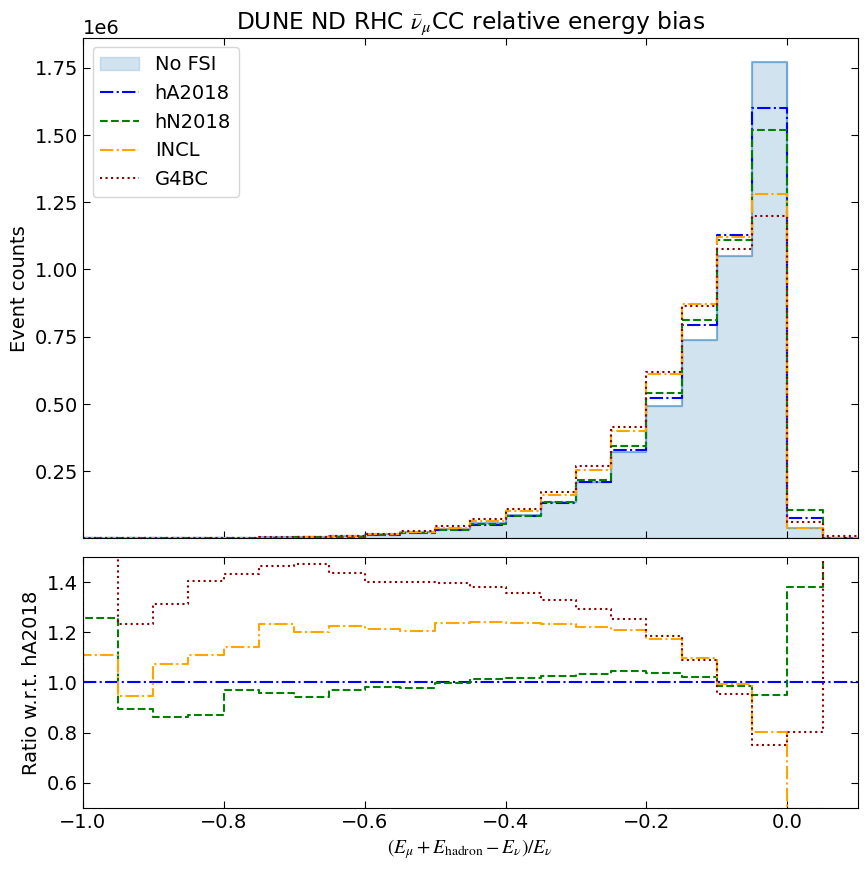

#events: 4728536 4762036 4764057 4741659 4679429


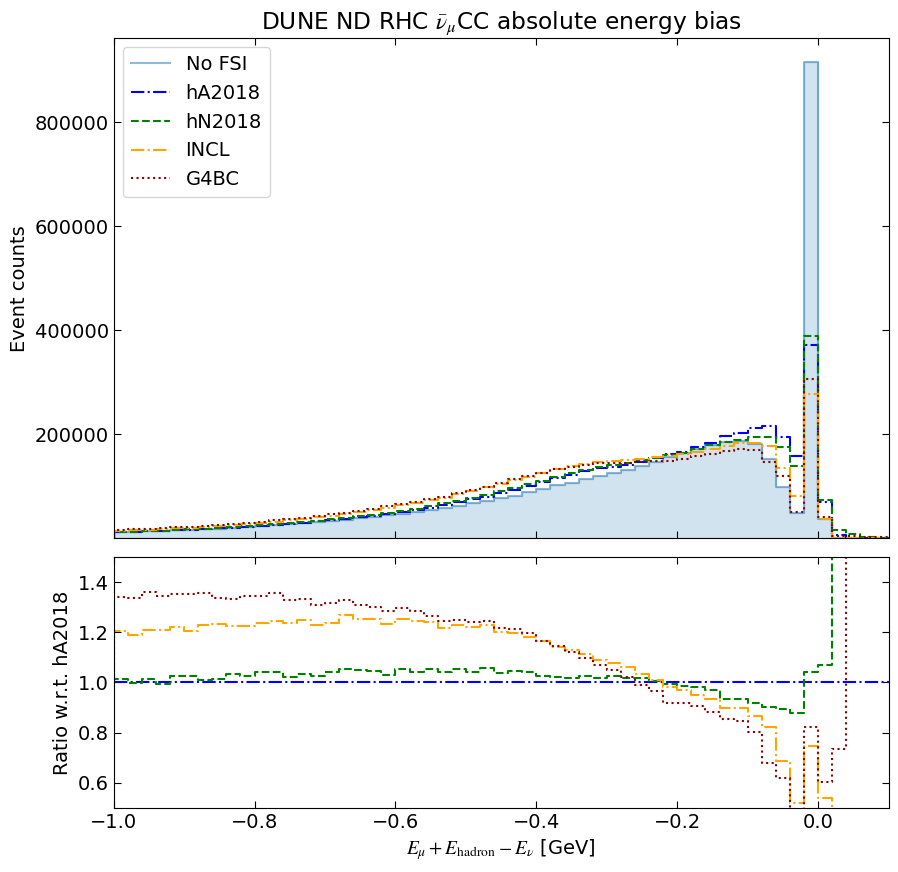

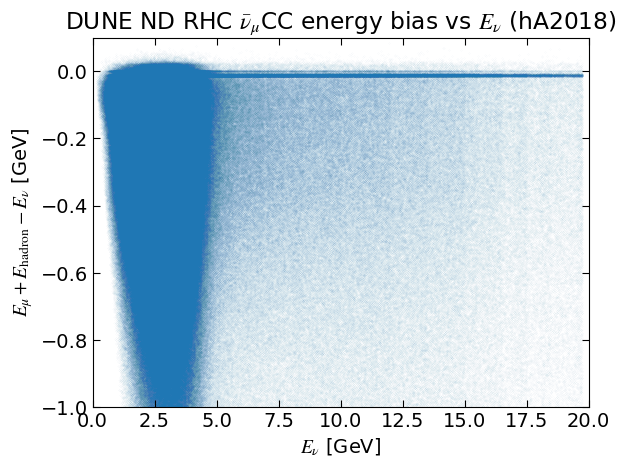

In [5]:
# relative energy bias
xx = np.linspace(-1, 0.1, 22+1)
yyi, _ = np.histogram(Ebiasi_numub_hA18/vars_numub_hA18["Ev"], bins=xx); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(Ebiasf_numub_hA18/vars_numub_hA18["Ev"], bins=xx); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(Ebiasf_numub_hN18/vars_numub_hN18["Ev"], bins=xx); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(Ebiasf_numub_INCL/vars_numub_INCL["Ev"], bins=xx); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(Ebiasf_numub_G4BC/vars_numub_G4BC["Ev"], bins=xx); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))
yyf_INCL = yyf_INCL*np.sum(yyi, dtype=float)/np.sum(yyf_INCL)

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

axes[0].step(xx, yyi, alpha=0.5, color='tab:blue')
axes[0].fill_between(xx, yyi, label="No FSI", step="pre", alpha=0.2, color='tab:blue')
axes[0].step(xx, yyf_hA18, "-.", label="hA2018", color='blue')
axes[0].step(xx, yyf_hN18, "--", label="hN2018", color='green')
axes[0].step(xx, yyf_INCL, "-.", label="INCL", color='orange')
axes[0].step(xx, yyf_G4BC, ":", label="G4BC", color='darkred')
axes[0].legend()
axes[0].set_ylabel("Event counts")
axes[0].set_title(r"DUNE ND RHC $\bar{\nu}_\mu$CC relative energy bias")
#axes[0].set_yscale('log')
axes[0].set_ylim([0.6, None])
axes[0].set_xlim([-1, 0.1])

axes[1].step(xx, safe_divide(yyf_hA18, yyf_hA18), "-.", label="hA2018", color='blue')
axes[1].step(xx, safe_divide(yyf_hN18, yyf_hA18), "--", label="hN2018", color='green')
axes[1].step(xx, safe_divide(yyf_INCL, yyf_hA18), "-.", label="INCL", color='orange')
axes[1].step(xx, safe_divide(yyf_G4BC, yyf_hA18), ":", label="G4BC", color='darkred')
axes[1].set_xlabel(r"$(E_\mu+E_{\rm hadron}-E_\nu)/E_\nu$")
axes[1].set_ylabel("Ratio w.r.t. hA2018")
axes[1].set_xlim([-1, 0.1])
axes[1].set_ylim([0.5, 1.5])
plt.savefig("FSIplots/relaEvbias_Ehadreco_FSI_numub.png")
plt.show()


# absolute energy bias
xlow, xupp = -1, 0.1
xx = np.linspace(xlow, xupp, 55+1)
yyi, _ = np.histogram(Ebiasi_numub_hA18, bins=xx); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(Ebiasf_numub_hA18, bins=xx); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(Ebiasf_numub_hN18, bins=xx); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(Ebiasf_numub_INCL, bins=xx); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(Ebiasf_numub_G4BC, bins=xx); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("#events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

axes[0].step(xx, yyi, label="No FSI", alpha=0.5, color='tab:blue')
axes[0].fill_between(xx, yyi, step="pre", alpha=0.2, color='tab:blue')
axes[0].step(xx, yyf_hA18, "-.", label="hA2018", color='blue')
axes[0].step(xx, yyf_hN18, "--", label="hN2018", color='green')
axes[0].step(xx, yyf_INCL, "-.", label="INCL", color='orange')
axes[0].step(xx, yyf_G4BC, ":", label="G4BC", color='darkred')
axes[0].legend()
axes[0].set_ylabel("Event counts")
axes[0].set_title(r"DUNE ND RHC $\bar{\nu}_\mu$CC absolute energy bias")
#axes[0].set_yscale('log')
axes[0].set_ylim([0.6, None])
axes[0].set_xlim([xlow, xupp])

axes[1].step(xx, safe_divide(yyf_hA18, yyf_hA18), "-.", label="hA2018", color='blue')
axes[1].step(xx, safe_divide(yyf_hN18, yyf_hA18), "--", label="hN2018", color='green')
axes[1].step(xx, safe_divide(yyf_INCL, yyf_hA18), "-.", label="INCL", color='orange')
axes[1].step(xx, safe_divide(yyf_G4BC, yyf_hA18), ":", label="G4BC", color='darkred')
axes[1].set_xlabel(r"$E_\mu+E_{\rm hadron}-E_\nu$ [GeV]")
axes[1].set_ylabel("Ratio w.r.t. hA2018")
axes[1].set_xlim([xlow, xupp])
axes[1].set_ylim([0.5, 1.5])
#plt.savefig("FSIplots/absoEvbias_Eavail_FSI_numub.png")
plt.show()


# energy bias vs neutrino energy
plt.scatter(vars_numub_hA18["Ev"], Ebiasf_numub_hA18, alpha=0.1, s=0.01)
plt.xlabel(r"$E_\nu$ [GeV]")
plt.ylabel(r"$E_\mu+E_{\rm hadron}-E_\nu$ [GeV]")
plt.xlim(0, 20)
plt.ylim(xlow, xupp)
plt.title(r"DUNE ND RHC $\bar{\nu}_\mu$CC energy bias vs $E_\nu$ (hA2018)")
#plt.savefig("FSIplots/2DEvbias_Eavail_hA18_numub.png")
plt.show()

/tmp/ipykernel_944/2242650362.py:2: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_numub_1300 = FDosc_Flux_RHCnumub_1300*1e7/ND_Flux_RHCnumubar


Check if all having the same #events: 9.999999999999998 10.0 10.0 10.000000000000002 10.0


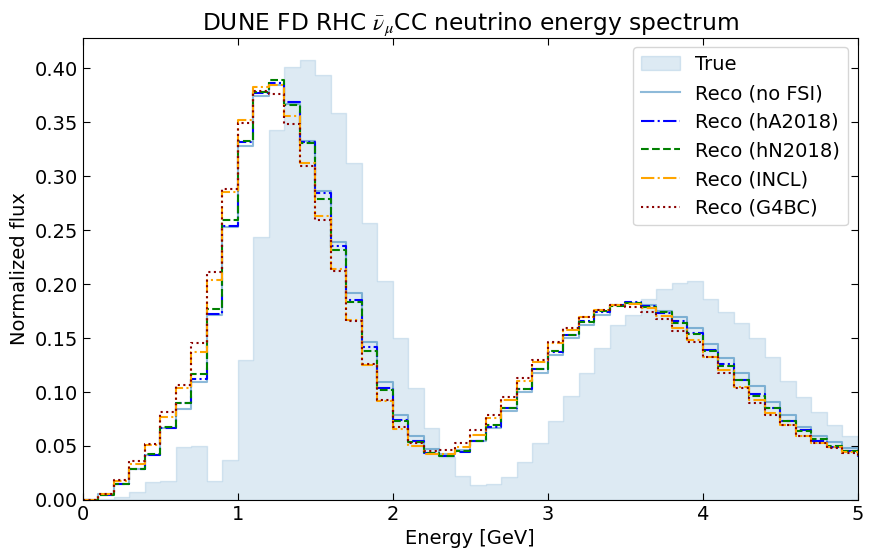

In [6]:
# oscillation
fluxND2FD_numub_1300 = FDosc_Flux_RHCnumub_1300*1e7/ND_Flux_RHCnumubar
ND2FD_numub_wei_hA18 = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_1300)
ND2FD_numub_wei_hN18 = np.interp(vars_numub_hN18["Ev"], FDosc_Ev, fluxND2FD_numub_1300)
ND2FD_numub_wei_INCL = np.interp(vars_numub_INCL["Ev"], FDosc_Ev, fluxND2FD_numub_1300)
ND2FD_numub_wei_G4BC = np.interp(vars_numub_G4BC["Ev"], FDosc_Ev, fluxND2FD_numub_1300)

xx = np.arange(0, 20+0.1, 0.1)
yyt, _ = np.histogram(vars_numub_hA18["Ev"], bins=xx, weights=ND2FD_numub_wei_hA18, density=True); yyt = np.concatenate([[0],yyt])
yyi, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasi_numub_hA18, bins=xx, weights=ND2FD_numub_wei_hA18, density=True); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_hA18, density=True); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(vars_numub_hN18["Ev"]+Ebiasf_numub_hN18, bins=xx, weights=ND2FD_numub_wei_hN18, density=True); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(vars_numub_INCL["Ev"]+Ebiasf_numub_INCL, bins=xx, weights=ND2FD_numub_wei_INCL, density=True); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(vars_numub_G4BC["Ev"]+Ebiasf_numub_G4BC, bins=xx, weights=ND2FD_numub_wei_G4BC, density=True); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(xx, yyt, step="pre", label="True", alpha=0.15, color='tab:blue')
ax.step(xx, yyi, label="Reco (no FSI)", alpha=0.5, color='tab:blue')
ax.step(xx, yyf_hA18, "-.", label="Reco (hA2018)", color='blue')
ax.step(xx, yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax.step(xx, yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax.step(xx, yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Normalized flux")
ax.set_title(r"DUNE FD RHC $\bar{\nu}_\mu$CC neutrino energy spectrum")
ax.set_ylim([0, None])
ax.set_xlim([0, 5])
plt.savefig("FSIplots/FDoscNv_Ehadreco_FSI_numub.png")
plt.show()

/tmp/ipykernel_944/1546853717.py:2: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_numub_m23p = FDosc_Flux_RHCnumub_m23p*1e7/ND_Flux_RHCnumubar
/tmp/ipykernel_944/1546853717.py:3: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_numub_m23m = FDosc_Flux_RHCnumub_m23m*1e7/ND_Flux_RHCnumubar
/tmp/ipykernel_944/1546853717.py:4: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_numub_m232p = FDosc_Flux_RHCnumub_m232p*1e7/ND_Flux_RHCnumubar
/tmp/ipykernel_944/1546853717.py:5: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_numub_m232m = FDosc_Flux_RHCnumub_m232m*1e7/ND_Flux_RHCnumubar
/tmp/ipykernel_944/1546853717.py:6: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_numub_t23p = FDosc_Flux_RHCnumub_t23p*1e7/ND_Flux_RHCnumubar
/tmp/ipykernel_944/1546853717.py:7: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_numub_t23m = FDosc_Flux_RHCnumub_t23m*1e7/ND_Flux_RHCnumubar
/tmp/ipykernel_944/1546853717.

Check if all having the same #events: 2311382.7052824525 10.0 2314822.7025442943 2312763.590742136 2310914.270075797


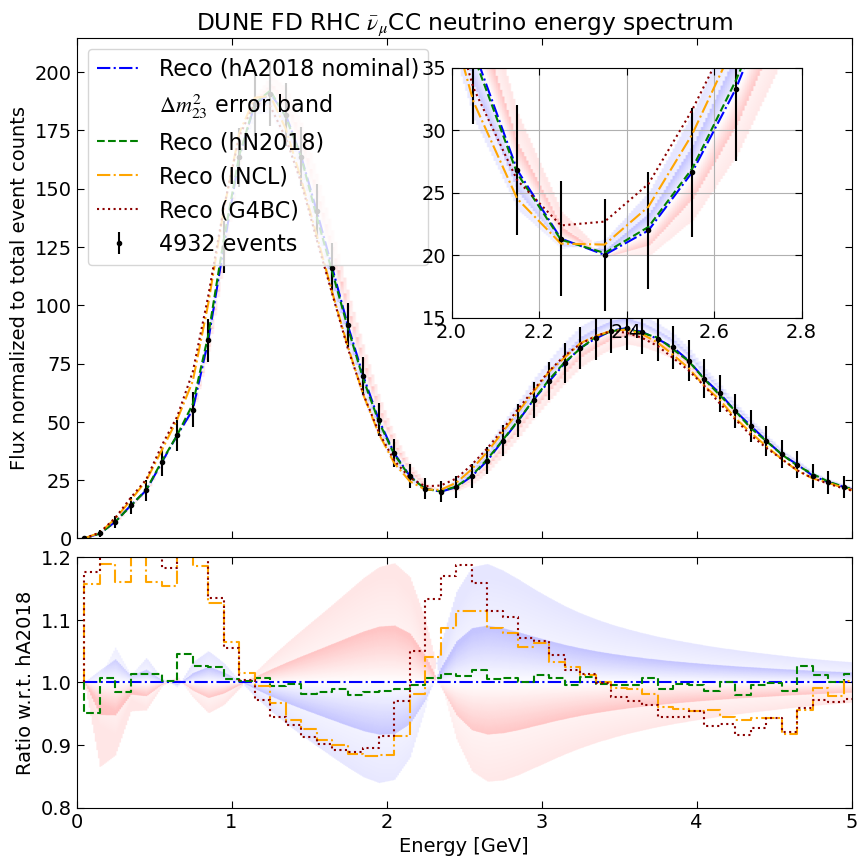

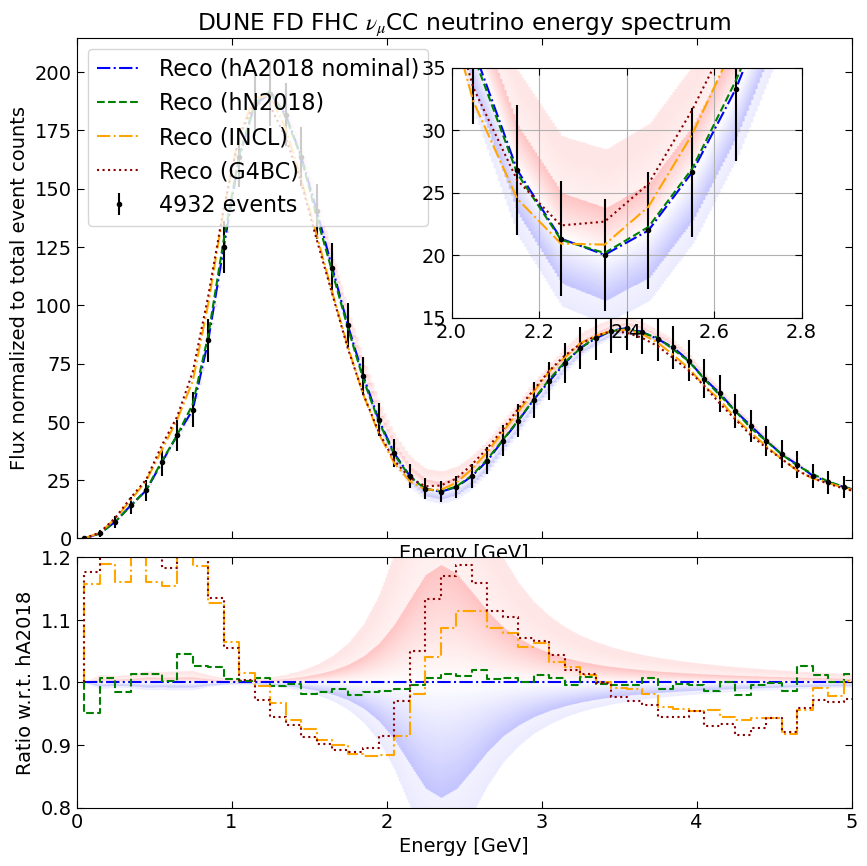

In [7]:
### oscillation sensitivity
fluxND2FD_numub_m23p = FDosc_Flux_RHCnumub_m23p*1e7/ND_Flux_RHCnumubar
fluxND2FD_numub_m23m = FDosc_Flux_RHCnumub_m23m*1e7/ND_Flux_RHCnumubar
fluxND2FD_numub_m232p = FDosc_Flux_RHCnumub_m232p*1e7/ND_Flux_RHCnumubar
fluxND2FD_numub_m232m = FDosc_Flux_RHCnumub_m232m*1e7/ND_Flux_RHCnumubar
fluxND2FD_numub_t23p = FDosc_Flux_RHCnumub_t23p*1e7/ND_Flux_RHCnumubar
fluxND2FD_numub_t23m = FDosc_Flux_RHCnumub_t23m*1e7/ND_Flux_RHCnumubar
fluxND2FD_numub_t232p = FDosc_Flux_RHCnumub_t232p*1e7/ND_Flux_RHCnumubar
fluxND2FD_numub_t232m = FDosc_Flux_RHCnumub_t232m*1e7/ND_Flux_RHCnumubar

ND2FD_numub_wei_1300 = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_1300)
ND2FD_numub_wei_m23p = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_m23p)
ND2FD_numub_wei_m23m = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_m23m)
ND2FD_numub_wei_m232p = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_m232p)
ND2FD_numub_wei_m232m = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_m232m)
ND2FD_numub_wei_t23p = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_t23p)
ND2FD_numub_wei_t23m = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_t23m)
ND2FD_numub_wei_t232p = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_t232p)
ND2FD_numub_wei_t232m = np.interp(vars_numub_hA18["Ev"], FDosc_Ev, fluxND2FD_numub_t232m)

xx = np.arange(0, 20+0.1, 0.1)
yyi, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasi_numub_hA18, bins=xx, weights=ND2FD_numub_wei_hA18, density=False); #yyi = np.concatenate([[0],yyi])
yyf_hN18, _ = np.histogram(vars_numub_hN18["Ev"]+Ebiasf_numub_hN18, bins=xx, weights=ND2FD_numub_wei_hN18, density=False); #yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(vars_numub_INCL["Ev"]+Ebiasf_numub_INCL, bins=xx, weights=ND2FD_numub_wei_INCL, density=False); #yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(vars_numub_G4BC["Ev"]+Ebiasf_numub_G4BC, bins=xx, weights=ND2FD_numub_wei_G4BC, density=False); #yyf_G4BC = np.concatenate([[0],yyf_G4BC])
yyf_1300, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_1300, density=False); #yyf_1300 = np.concatenate([[0],yyf_1300])
yyf_m23p, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_m23p, density=False); #yyf_m23p = np.concatenate([[0],yyf_m23p])
yyf_m23m, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_m23m, density=False); #yyf_m23m = np.concatenate([[0],yyf_m23m])
yyf_m232p, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_m232p, density=False); #yyf_m232p = np.concatenate([[0],yyf_m232p])
yyf_m232m, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_m232m, density=False); #yyf_m232m = np.concatenate([[0],yyf_m232m])
yyf_t23p, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_t23p, density=False); #yyf_t23p = np.concatenate([[0],yyf_t23p])
yyf_t23m, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_t23m, density=False); #yyf_t23m = np.concatenate([[0],yyf_t23m])
yyf_t232p, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_t232p, density=False); #yyf_t232p = np.concatenate([[0],yyf_t232p])
yyf_t232m, _ = np.histogram(vars_numub_hA18["Ev"]+Ebiasf_numub_hA18, bins=xx, weights=ND2FD_numub_wei_t232m, density=False); #yyf_t232m = np.concatenate([[0],yyf_t232m])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

Nv = int(2656 *624/336) # estimated total event counts
scale = Nv/np.sum(yyf_1300)
xx = (xx[1:]+xx[:-1])/2

### Δm^2_{23}
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})
ax[0].plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax[0].errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
ax[0].fill_between(xx, scale*yyf_m23m, scale*yyf_m23p, label=r"$\Delta m^2_{23}$ error band", alpha=0, color='tab:blue')
#ax[0].fill_between(xx, scale*yyf_m232m, scale*yyf_m232p, alpha=0.1, color='tab:blue')
fill_between_gradient(ax[0], xx, scale*yyf_1300, scale*yyf_m23p, scale*yyf_m23m, alpha=0.2, label=r"$\Delta m^2_{23}$ error band")
fill_between_gradient(ax[0], xx, scale*yyf_1300, scale*yyf_m232p, scale*yyf_m232m, alpha=0.1)
#ax[0].plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax[0].plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax[0].plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax[0].plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax[0].legend(loc="upper left", fontsize=16)
#ax[0].set_xlabel("Energy [GeV]")
ax[0].set_ylabel("Flux normalized to total event counts")
ax[0].set_title(r"DUNE FD RHC $\bar{\nu}_\mu$CC neutrino energy spectrum")
ax[0].set_ylim([0, None])
ax[0].set_xlim([0, 5])

ax_inset = fig.add_axes([0.5, 0.6, 0.35, 0.25])  # Adjust these values as needed
# Plot the same data on the inset axes
ax_inset.plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
#ax_inset.fill_between(xx, scale*yyf_m23m, scale*yyf_m23p, label=r"$\Delta m^2_{23}$ error band", alpha=0.2, color='tab:blue')
#ax_inset.fill_between(xx, scale*yyf_m232m, scale*yyf_m232p, alpha=0.1, color='tab:blue')
fill_between_gradient(ax_inset, xx, scale*yyf_1300, scale*yyf_m23p, scale*yyf_m23m, alpha=0.2, resolution=4000)
fill_between_gradient(ax_inset, xx, scale*yyf_1300, scale*yyf_m232p, scale*yyf_m232m, alpha=0.1, resolution=4000)
ax_inset.errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
#ax_inset.plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax_inset.plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax_inset.plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax_inset.plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax_inset.set_ylim([15, 35])
ax_inset.set_xlim([2, 2.8])
ax_inset.grid(True)

ax[1].step(xx, safe_divide(yyf_1300, yyf_1300), "-.", label="hA2018", color='blue')
ax[1].step(xx, safe_divide(yyf_hN18, yyf_1300), "--", label="hN2018", color='green')
ax[1].step(xx, safe_divide(yyf_INCL, yyf_1300), "-.", label="INCL", color='orange')
ax[1].step(xx, safe_divide(yyf_G4BC, yyf_1300), ":", label="G4BC", color='darkred')
#ax[1].fill_between(xx, safe_divide(yyf_m23m, yyf_1300), safe_divide(yyf_m23p, yyf_1300), alpha=0.2, color='tab:blue')
#ax[1].fill_between(xx, safe_divide(yyf_m232m, yyf_1300), safe_divide(yyf_m232p, yyf_1300), alpha=0.1, color='tab:blue')
fill_between_gradient(ax[1], xx, np.ones_like(xx), safe_divide(yyf_m23p, yyf_1300), safe_divide(yyf_m23m, yyf_1300), alpha=0.2, resolution=2000)
fill_between_gradient(ax[1], xx, np.ones_like(xx), safe_divide(yyf_m232p, yyf_1300), safe_divide(yyf_m232m, yyf_1300), alpha=0.1, resolution=2000)

ax[1].set_xlabel(r"Energy [GeV]")
ax[1].set_ylabel("Ratio w.r.t. hA2018")
ax[1].set_ylim([0.8, 1.2])
plt.savefig("FSIplots/FDoscNv_Ehadrec_FSI_numub_m23.png")
plt.show()


### sin^2 θ_{23}
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})
ax[0].plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax[0].errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
#ax[0].fill_between(xx, scale*yyf_t23m, scale*yyf_t23p, label=r"$\sin^2 \theta_{23}$ error band", alpha=0.2, color='tab:red')
#ax[0].fill_between(xx, scale*yyf_t232m, scale*yyf_t232p, alpha=0.1, color='tab:red')
fill_between_gradient(ax[0], xx, scale*yyf_1300, scale*yyf_t23p, scale*yyf_t23m, alpha=0.2)
fill_between_gradient(ax[0], xx, scale*yyf_1300, scale*yyf_t232p, scale*yyf_t232m, alpha=0.1)
#ax[0].plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax[0].plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax[0].plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax[0].plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax[0].legend(loc="upper left", fontsize=16)
ax[0].set_xlabel("Energy [GeV]")
ax[0].set_ylabel("Flux normalized to total event counts")
ax[0].set_title(r"DUNE FD FHC $\nu_\mu$CC neutrino energy spectrum")
ax[0].set_ylim([0, None])
ax[0].set_xlim([0, 5])

ax_inset = fig.add_axes([0.5, 0.6, 0.35, 0.25])  # Adjust these values as needed
# Plot the same data on the inset axes
ax_inset.plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax_inset.errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
ax_inset.fill_between(xx, scale*yyf_t23m, scale*yyf_t23p, label=r"$\sin^2 \theta_{23}$ error band", alpha=0, color='tab:red')
#ax_inset.fill_between(xx, scale*yyf_t232m, scale*yyf_t232p, alpha=0.1, color='tab:red')
fill_between_gradient(ax_inset, xx, scale*yyf_1300, scale*yyf_t23p, scale*yyf_t23m, alpha=0.2, resolution=4000)
fill_between_gradient(ax_inset, xx, scale*yyf_1300, scale*yyf_t232p, scale*yyf_t232m, alpha=0.1, resolution=4000)
#ax_inset.plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax_inset.plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax_inset.plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax_inset.plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax_inset.set_ylim([15, 35])
ax_inset.set_xlim([2, 2.8])
ax_inset.grid(True)

ax[1].step(xx, safe_divide(yyf_1300, yyf_1300), "-.", label="hA2018", color='blue')
ax[1].step(xx, safe_divide(yyf_hN18, yyf_1300), "--", label="hN2018", color='green')
ax[1].step(xx, safe_divide(yyf_INCL, yyf_1300), "-.", label="INCL", color='orange')
ax[1].step(xx, safe_divide(yyf_G4BC, yyf_1300), ":", label="G4BC", color='darkred')
#ax[1].fill_between(xx, safe_divide(yyf_t23m, yyf_1300), safe_divide(yyf_t23p, yyf_1300), alpha=0.2, color='tab:red')
#ax[1].fill_between(xx, safe_divide(yyf_t232m, yyf_1300), safe_divide(yyf_t232p, yyf_1300), alpha=0.1, color='tab:red')
fill_between_gradient(ax[1], xx, np.ones_like(xx), safe_divide(yyf_t23p, yyf_1300), safe_divide(yyf_t23m, yyf_1300), alpha=0.2, resolution=2000)
fill_between_gradient(ax[1], xx, np.ones_like(xx), safe_divide(yyf_t232p, yyf_1300), safe_divide(yyf_t232m, yyf_1300), alpha=0.1, resolution=2000)
ax[1].set_xlabel(r"Energy [GeV]")
ax[1].set_ylabel("Ratio w.r.t. hA2018")
ax[1].set_ylim([0.8, 1.2])
plt.savefig("FSIplots/FDoscNv_Ehadrec_FSI_numub_t23.png")
plt.show()
